# Project 1 - Lung Cancer Classification using Computerized Tomography (CT) Data

## Introdução

O cancro do pulmão é uma das principais causas de morte relacionada com o cancro a nível mundial. A identificação prévia de nódulos malignos é fundamental para aumentar a taxa de sobrevivência dos pacientes.

O objetivo deste trabalho é desenvolver uma solução para **classificação de nódulos pulmonares** como *benignos* ou *malignos*, utilizando imagens CT provenientes do **conjunto de dados público LIDC-IDRI**. 

Para atingir o nosso objetivo, serão usados metodos de pré-processamento de dados, extração de *features* e modelação através de algoritmos de *Machine Learning*. O desempenho dos modelos será avaliado por meio de métricas adequadas.

O trabalho segue uma abordagem inspirada na metodologia **CRISP-DM**, abrangendo as etapas de:
- Compreensão do problema e dos dados;
- Preparação e limpeza dos dados;
- Modelação e otimização;
- Avaliação dos resultados;
- Discussão de implicações éticas e legais.

In [109]:
#importações necessarias
import pandas as pd
import numpy as np
import pylidc as pl
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import measure
import SimpleITK as sitk
import radiomics 
from radiomics import featureextractor
import configparser
configparser.SafeConfigParser = configparser.ConfigParser  
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.stats import zscore
from skimage.draw import polygon
from math import pi

## 1 - Criação e Análise dos Diferentes *Datasets*

**Objetivo:** Analisar e compreender os dados, de forma a identificar quais *datasets* e informações são mais adequados para a tarefa de **classificação de cancro do pulmão**.  

Esta análise inicial é essencial para garantir que os modelos recebam dados **consistentes, relevantes e de alta qualidade**, diminuindo potenciais fontes de ruído ou viés nos resultados.

### 1.1 - *Dataset* lidc-idri-nodule-counts

**Descrição:** Este *dataset* contém informações sobre o **número de nódulos detetados por paciente**, tal como **número de nódulos>=3** e  **número de nódulos<3** permitindo uma visão geral da distribuição de casos.

**Pré-processamento realizado:**  
- Remoção de colunas consideradas irrelevantes para a análise;  
- Eliminação de registos com **valores ausentes** (*missing values*) ou inconsistentes, de modo a **assegurar a integridade e fiabilidade** do conjunto de dados;
- Verificação da coerência entre o número de nódulos e o número de anotações disponíveis, garantindo consistência antes da fusão com outros *datasets*.


In [110]:
df1 = pd.read_excel(r"lidc-idri-nodule-counts-6-23-2015.xlsx")
df1.shape

(1019, 6)

In [111]:
#verificação de valores ausentes
print(df1.isna().sum())

TCIA Patent ID                  1
Total Number of Nodules*        0
Number of Nodules >=3mm**       0
Number of Nodules <3mm***       0
Unnamed: 4                   1019
Unnamed: 5                   1016
dtype: int64


In [112]:
df1 = df1.iloc[:, :-2]
df1=df1.drop(df1.index[-1])
df1.columns = ['patient_id', 'Total Number of Nodules', 'Number of Nodules>=3',
 'Number of Nodules <3mm']
df1['patient_id'].nunique()

1010

In [113]:
#verificar se o nº total de nodulos= nºnodulos>=3 + nºnodulos<3
(df1['Total Number of Nodules'] == df1['Number of Nodules>=3'] + df1['Number of Nodules <3mm']).all()

True

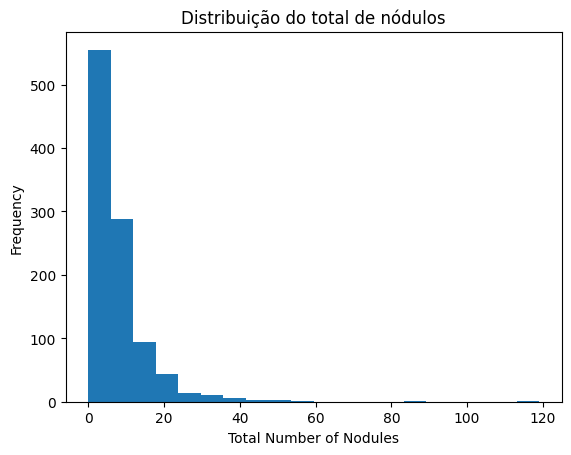

In [114]:
# Histograma do total de nódulos 
df1['Total Number of Nodules'].plot(kind="hist", bins=20, title="Distribuição do total de nódulos")
plt.xlabel("Total Number of Nodules")
plt.show()

**Observações:** O gráfico acima mostra a **distribuição do número total de nódulos por paciente**. Observa-se uma **distribuição assimétrica à direita**, onde a maioria dos pacientes apresenta entre **1 a 10 nódulos**, enquanto alguns casos isolados têm valores muito superiores.
Esses valores extremos podem ter origem em:
- pacientes com múltiplos nódulos benignos ou casos clínicos atípicos;
- erros de anotação.

**Nota:** A presença dessa assimetria é normal em bases médicas e reforça a necessidade de **normalização e controle de outliers** em etapas posteriores de pré-processamento.

### 1.2- Dataset *tcia-diagnosis-data* 
- **Descrição:** Este dataset contém informações detalhadas sobre os pacientes e seus nódulos, incluindo o **nível de diagnóstico**, o **método utilizado** e o **tipo de tumor primário associado**. 
- **Pré-processamento realizado:** 
    - Remoção de colunas irrelevantes ou redundantes. 
    - Tratamento de valores ausentes e inconsistentes para garantir a integridade dos dados.


In [115]:
df2 = pd.read_excel(r"tcia-diagnosis-data-2012-04-20.xls")
df2.columns = ['patient_id', 'Diagnosis at the Patient Level', 'Diagnosis Method at the Nodule',
 'Primary tumor site for metastatic disease',
 'Nodule 1 Diagnosis at the Nodule Level', 'Nodule 1 Diagnosis',
 'Nodule 2 Diagnosis at the Nodule Level', 'Nodule 2 Diagnosis',
 'Nodule 3 Diagnosis at the Nodule Level', 'Nodule 3 Diagnosis',
 'Nodule 4 Diagnosis at the Nodule Level', 'Nodule 4 Diagnosis',
 'Nodule 5 Diagnosis at the Nodule Level', 'Nodule 5 Diagnosis']
df2.shape

(157, 14)

In [116]:
print(df2.isna().sum())

patient_id                                     0
Diagnosis at the Patient Level                 0
Diagnosis Method at the Nodule                 0
Primary tumor site for metastatic disease      0
Nodule 1 Diagnosis at the Nodule Level        20
Nodule 1 Diagnosis                            20
Nodule 2 Diagnosis at the Nodule Level       137
Nodule 2 Diagnosis                           137
Nodule 3 Diagnosis at the Nodule Level       156
Nodule 3 Diagnosis                           156
Nodule 4 Diagnosis at the Nodule Level       157
Nodule 4 Diagnosis                           157
Nodule 5 Diagnosis at the Nodule Level       157
Nodule 5 Diagnosis                           157
dtype: int64


In [117]:
#reemoção de colunas com grande quantidade de NaN
df2 = df2.drop(columns=df2.columns[-6:])
df2.head()

,patient_id,Diagnosis at the Patient Level,Diagnosis Method at the Nodule,Primary tumor site for metastatic disease,Nodule 1 Diagnosis at the Nodule Level,Nodule 1 Diagnosis,Nodule 2 Diagnosis at the Nodule Level,Nodule 2 Diagnosis
0,LIDC-IDRI-0068,3,4,Head & Neck Cancer,3.0,4.0,NaN,NaN
1,LIDC-IDRI-0071,3,1,Head & Neck,1.0,1.0,NaN,NaN
2,LIDC-IDRI-0072,2,4,Lung Cancer,1.0,4.0,NaN,NaN
3,LIDC-IDRI-0088,3,0,Uterine Cancer,0.0,0.0,NaN,NaN
4,LIDC-IDRI-0090,2,3,NSCLC,2.0,3.0,NaN,NaN


In [118]:
df2['patient_id'].nunique()

157

### 1.3 - Extração e Estruturação das Anotações Radiológicas com PyLIDC

O pacote **PyLIDC** foi utilizado para processar e converter as anotações dos radiologistas do *dataset* **LIDC-IDRI**.  
Cada exame de tomografia computadorizada (CT) no LIDC contém até **quatro anotações independentes**, registadas em formato XML.  
Essas anotações incluem contornos manuais e descritores visuais dos nódulos pulmonares.

**Objetivo:**  
Transformar as anotações XML numa tabela(*dataset*) consolidada, onde cada linha representa **um nódulo avaliado por um radiologista**.

**Etapas do processo:**
1. **Leitura das anotações via PyLIDC:**  
   Cada *scan* foi processada individualmente, acedendo às anotações através de *pl.query(pl.Scan)*.  
   O PyLIDC converte internamente o XML em objetos Python, permitindo acesso direto aos atributos das anotações.

2. **Criação de identificadores únicos:**  
   Foi implementado um contador (*patient_ann_counters*) para garantir que cada nódulo recebe um **ID sequencial por paciente** (*nodule_id*), mantendo a coerência entre as instâncias anotadas.

3. **Extração das características visuais LIDC:**  
   Para cada anotação, foram extraidas as seguintes *features* (escala 1–5 ou 1–6):  
   *subtlety*, *internalStructure*, *calcification*, *sphericity*, *margin*, *lobulation*, *spiculation*, *texture* e *malignancy*.

4. **Cálculo de atributos morfológicos auxiliares:**  
   O número de cortes (*num_slices*) foi calculado a partir dos contornos disponíveis, representando a espessura axial do nódulo.

5. **Verificação de consistência e remoção de duplicados:**  
   Após gerar o dataset, identificaram-se 8 pacientes com múltiplas instâncias de *study_instance_uid*, correspondendo a exames duplicados. Esses casos foram removidos.

**Importância:**  
Esta etapa é fundamental para garantir que cada nódulo tem uma representação única, coerente e interpretável.  
A consolidação das anotações radiológicas serve de base para:
- associar *labels* de malignidade e outras características clínicas às imagens processadas;   
- permitir o treinamento supervisionado de modelos de *Machine Learning* baseados em *features* visuais e radiômicas.

In [ ]:
# Patch temporário para compatibilidade NumPy >=2.0
import numpy as np
if not hasattr(np, "int"):
    np.int = int

def safe_float(obj, attr):
    v = getattr(obj, attr, None)
    try:
        return float(v)
    except Exception:
        return np.nan

rows = [] # vai acumular dicionários (uma linha por anotação)

# contador de anotações por paciente (persistente entre scans do mesmo paciente)
patient_ann_counters = {}

# percorre todos os scans/anotações
for scan in pl.query(pl.Scan):
    pid = scan.patient_id
    study_uid = scan.study_instance_uid
    series_uid = scan.series_instance_uid

    # inicializa contador do paciente se ainda não existir
    if pid not in patient_ann_counters:
        patient_ann_counters[pid] = 0


    for ann in scan.annotations:
        # incrementa o contador de anotações desse paciente
        patient_ann_counters[pid] += 1
        ann_index = patient_ann_counters[pid]

        # Agrupa anotações em blocos de 4 para definir um "nodule_id" sequencial:
        nodulo_num = (ann_index - 1) // 4 + 1

        # número de cortes (slices) com contornos neste nódulo
        try:
            num_slices = len(ann.contours)
        except Exception:
            num_slices = np.nan

        # ID da sessão de leitura (radiologista)
        reading_session_id = getattr(ann, "reading_session_id", None)

        rows.append({
            "patient_id": pid,
            "nodule_id": int(nodulo_num),
            "reading_session_id": reading_session_id,
            "num_slices": num_slices,
            "spiculation": safe_float(ann, "spiculation"),
            "lobulation": safe_float(ann, "lobulation"),
            "sphericity": safe_float(ann, "sphericity"),
            "margin": safe_float(ann, "margin"),
            "subtlety": safe_float(ann, "subtlety"),
            "texture": safe_float(ann, "texture"),
            "calcification": safe_float(ann, "calcification"),
            "malignancy": safe_float(ann, "malignancy"),
            "internal_structure": safe_float(ann, "internalStructure"),
            "study_instance_uid": study_uid,
            "series_instance_uid": series_uid
        })

df_annotations = pd.DataFrame(rows)
df_annotations.to_csv("annotations.csv", index=False)
print("Linhas:", len(df_annotations))
print("Colunas:", list(df_annotations.columns))


c:\Users\Matilde\3ano\1sem\LIACD\t1\py37\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


Linhas: 6859
Colunas: ['patient_id', 'nodule_id', 'reading_session_id', 'num_slices', 'spiculation', 'lobulation', 'sphericity', 'margin', 'subtlety', 'texture', 'calcification', 'malignancy', 'internal_structure', 'study_instance_uid', 'series_instance_uid']


In [119]:
df_annotations = pd.read_csv(r"annotations.csv")
df_annotations.shape

(6859, 15)

In [120]:
df_annotations.head()

,patient_id,nodule_id,reading_session_id,num_slices,spiculation,lobulation,sphericity,margin,subtlety,texture,calcification,malignancy,internal_structure,study_instance_uid,series_instance_uid
0,LIDC-IDRI-0078,1,NaN,6,1.0,1.0,3.0,4.0,5.0,5.0,6.0,3.0,1.0,1.3.6.1.4.1.14519.5.2.1.6279.6001.339170810277...,1.3.6.1.4.1.14519.5.2.1.6279.6001.303494235102...
1,LIDC-IDRI-0078,1,NaN,6,2.0,1.0,4.0,4.0,4.0,5.0,6.0,3.0,1.0,1.3.6.1.4.1.14519.5.2.1.6279.6001.339170810277...,1.3.6.1.4.1.14519.5.2.1.6279.6001.303494235102...
2,LIDC-IDRI-0078,1,NaN,8,3.0,2.0,3.0,5.0,5.0,5.0,4.0,4.0,1.0,1.3.6.1.4.1.14519.5.2.1.6279.6001.339170810277...,1.3.6.1.4.1.14519.5.2.1.6279.6001.303494235102...
3,LIDC-IDRI-0078,1,NaN,8,1.0,4.0,4.0,2.0,5.0,5.0,6.0,5.0,1.0,1.3.6.1.4.1.14519.5.2.1.6279.6001.339170810277...,1.3.6.1.4.1.14519.5.2.1.6279.6001.303494235102...
4,LIDC-IDRI-0078,2,NaN,6,1.0,3.0,4.0,2.0,4.0,4.0,6.0,4.0,1.0,1.3.6.1.4.1.14519.5.2.1.6279.6001.339170810277...,1.3.6.1.4.1.14519.5.2.1.6279.6001.303494235102...


In [121]:
df_annotations['patient_id'].nunique()

875

In [122]:
#Confirmar se há pacientes repetidos mas com study_instance_uid diferentes
count = df_annotations.groupby('patient_id')['study_instance_uid'].nunique()
count[count >= 2]

patient_id
LIDC-IDRI-0132    2
LIDC-IDRI-0151    2
LIDC-IDRI-0315    2
LIDC-IDRI-0332    2
LIDC-IDRI-0355    2
LIDC-IDRI-0365    2
LIDC-IDRI-0442    2
LIDC-IDRI-0484    2
Name: study_instance_uid, dtype: int64

In [123]:
# lista de pacientes a remover
remover = [
    "LIDC-IDRI-0132",
    "LIDC-IDRI-0151",
    "LIDC-IDRI-0315",
    "LIDC-IDRI-0332",
    "LIDC-IDRI-0355",
    "LIDC-IDRI-0365",
    "LIDC-IDRI-0442",
    "LIDC-IDRI-0484"
]

# filtrar o DataFrame mantendo apenas os que não estão na lista
df_annotations= df_annotations[~df_annotations["patient_id"].isin(remover)]

In [124]:
df_annotations['patient_id'].nunique()

867

### 1.4 - Consolidação dos *Datasets* num Único Arquivo

Após a análise de cada fonte de dados, foi realizada a **integração dos *datasets*** relevantes para a construção de uma base consolidada para ser usada na modelação preditiva da malignidade dos nódulos pulmonares.

#### Objetivo
Criar um **dataset unificado**, combinando as contagens de nódulos por paciente com as **características visuais anotadas pelos radiologistas**.  
Desta forma, cada linha da base final representa **um nódulo único**, associado a:
- um paciente específico,
- suas propriedades morfológicas e visuais,
- e informações auxiliares extraídas dos ficheiros originais do LIDC-IDRI.

#### *Datasets* selecionados
- **lidc-idri-nodule-counts**  
  Contém a contagem total de nódulos por paciente, bem como a separação entre nódulos >=3 mm e <3 mm.  
  Este dataset permite identificar pacientes com múltiplos nódulos e avaliar possíveis relações entre **número total de nódulos** e **probabilidade de malignidade**.

- **annotations.csv**  
  Inclui as **anotações dos radiologistas**, com as *features* visuais (subtlety, margin, lobulation, spiculation, texture, malignancy, etc.) e metadados de cada nódulo, como study_instance_uid, series_uid e num_slices.  

#### *Dataset* excluído
- **tcia-diagnosis-data**  
  Apesar de conter diagnósticos clínicos, este dataset foi **excluído** devido à **elevada taxa de valores ausentes** (apenas 157 pacientes registados).  
  Segundo a literatura, dados com cobertura tão limitada introduzem **viés e inconsistência amostral**, sendo inadequados para treino de modelos de *Machine Learning*.

#### Estratégia de fusão dos dados
A fusão foi realizada utilizando as chaves:
- patient_id (identificador único do paciente);

O *merge* foi do tipo **inner join**, de modo a garantir que apenas nódulos com correspondência em ambas as tabelas fossem mantidos, assegurando **integridade e consistência** da informação.

In [125]:
df = pd.merge(df1, df_annotations, on='patient_id', how='inner')
df.head()

,patient_id,Total Number of Nodules,Number of Nodules>=3,Number of Nodules <3mm,nodule_id,reading_session_id,num_slices,spiculation,lobulation,sphericity,margin,subtlety,texture,calcification,malignancy,internal_structure,study_instance_uid,series_instance_uid
0,LIDC-IDRI-0001,4,1,3,1,NaN,8,4.0,3.0,3.0,3.0,5.0,5.0,6.0,5.0,1.0,1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...,1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...
1,LIDC-IDRI-0001,4,1,3,1,NaN,7,5.0,5.0,4.0,4.0,5.0,5.0,6.0,5.0,1.0,1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...,1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...
2,LIDC-IDRI-0001,4,1,3,1,NaN,8,3.0,3.0,3.0,2.0,5.0,5.0,6.0,5.0,1.0,1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...,1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...
3,LIDC-IDRI-0001,4,1,3,1,NaN,9,5.0,1.0,5.0,4.0,5.0,4.0,6.0,4.0,1.0,1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...,1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...
4,LIDC-IDRI-0002,12,1,11,1,NaN,30,1.0,1.0,5.0,1.0,2.0,1.0,6.0,5.0,1.0,1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160...,1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417...


In [126]:
df[df['Total Number of Nodules']==0]

,patient_id,Total Number of Nodules,Number of Nodules>=3,Number of Nodules <3mm,nodule_id,reading_session_id,num_slices,spiculation,lobulation,sphericity,margin,subtlety,texture,calcification,malignancy,internal_structure,study_instance_uid,series_instance_uid


In [127]:
df[df['Number of Nodules>=3']==0]

,patient_id,Total Number of Nodules,Number of Nodules>=3,Number of Nodules <3mm,nodule_id,reading_session_id,num_slices,spiculation,lobulation,sphericity,margin,subtlety,texture,calcification,malignancy,internal_structure,study_instance_uid,series_instance_uid


In [128]:
#Confirmar se há pacientes repetidos mas com nº de nódulos diferentes
count = df.groupby('patient_id')['Total Number of Nodules'].nunique()
count[count >= 2]

Series([], Name: Total Number of Nodules, dtype: int64)

In [129]:
count = df.groupby('patient_id')['Number of Nodules>=3'].nunique()
count[count >= 2]

Series([], Name: Number of Nodules>=3, dtype: int64)

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6728 entries, 0 to 6727
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   patient_id               6728 non-null   object 
 1   Total Number of Nodules  6728 non-null   int64  
 2   Number of Nodules>=3     6728 non-null   int64  
 3   Number of Nodules <3mm   6728 non-null   int64  
 4   nodule_id                6728 non-null   int64  
 5   reading_session_id       0 non-null      float64
 6   num_slices               6728 non-null   int64  
 7   spiculation              6728 non-null   float64
 8   lobulation               6728 non-null   float64
 9   sphericity               6728 non-null   float64
 10  margin                   6728 non-null   float64
 11  subtlety                 6728 non-null   float64
 12  texture                  6728 non-null   float64
 13  calcification            6728 non-null   float64
 14  malignancy              

In [131]:
df = df.drop(columns="reading_session_id")

In [132]:
#Passar de floats para inteiros
colunas=['spiculation','lobulation','sphericity','margin',
         'subtlety','texture', 'calcification', 'malignancy', 'internal_structure'
        ]
df[colunas]=df[colunas].astype(int)

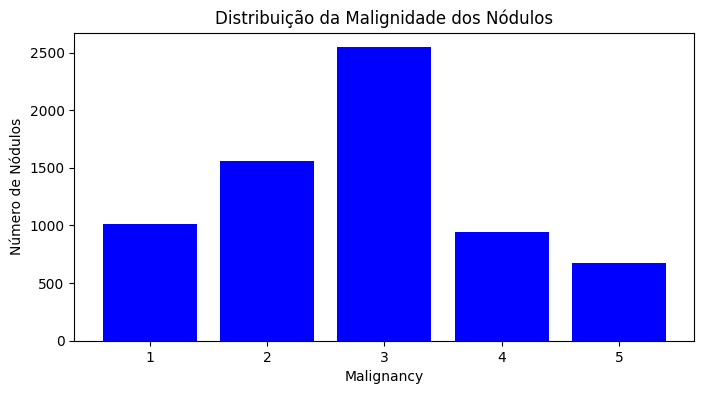

In [133]:
counts = df['malignancy'].value_counts().sort_index() 
labels = counts.index.astype(str)  
plt.figure(figsize=(8,4))
plt.bar(labels, counts, color='blue')
plt.xlabel('Malignancy')
plt.ylabel('Número de Nódulos')
plt.title('Distribuição da Malignidade dos Nódulos')
plt.show()

### 1.5 - Alterar *malignancy* para Valores Binários e Consolidação das Anotações

Para treinar modelos de classificação binária, foi necessário transformar a variável *malignancy* em valores **0 (benigno)** e **1 (maligno)**, bem como **agregar as anotações de cada nódulo** num único registo representativo.

#### Estratégias consideradas
Foram analisadas várias abordagens para consolidar as anotações feitas sobre o mesmo nódulo:

- **Média aritmética:** Simples de calcular e assume que a escala é contínua. No entanto, pode ser influenciada por valores extremos.  
- **Mediana:** Mais robusta a *outliers* e mais adequada para variáveis ordinais, preservando o consenso central entre os radiologistas.  
- **Moda (consenso simples):** Representa a categoria mais frequente, sendo intuitiva para variáveis nominais, mas pode gerar empates em caso de desacordo entre radiologistas.

#### Estratégia aplicada
Optou-se por utilizar a **mediana para todas as variáveis avaliadas em escala ordinal (1–5)**, incluindo *malignancy* e outras características visuais dos nódulos (*spiculation*, *lobulation*, *sphericity*, *margin*, *subtlety*, *texture*).  

- **Justificação:**  
  A mediana é a medida mais adequada para este tipo de variável, pois é **robusta a discrepâncias inter-observador**.  
  Além disso, diminui o impacto de avaliações extremas, garantindo que cada nódulo seja representado por um valor central estável e clinicamente interpretável.  

Para as variáveis **categóricas não ordinais** (*calcification* e *internal_structure*), utilizou-se a **moda**, que reflete o consenso mais frequente entre os radiologistas.

#### Binarização de *malignancy*
Aplicou-se a seguinte regra de binarização:
- Valores **≤ 2.5 → 0 (benigno)**  
- Valores **≥ 3.5 → 1 (maligno)**  
- Valores próximos **3.0** foram considerados **indeterminados** e removidos.

**Justificação:**  
- A exclusão dos casos “3” evita introduzir ruído nas classes, uma vez que estes nódulos são **ambíguos**.  
- A divisão segue práticas adotadas em múltiplos trabalhos radiômicos que utilizam o LIDC-IDRI, favorecendo a **consistência metodológica e comparabilidade de resultados**.

In [134]:
#função auxiliar: faz a moda ignorando os NaN
def mode_safe(x):
    m = x.mode(dropna=True)
    return m.iloc[0] if not m.empty else np.nan

# colunas por tipo de agregação
mode_cols = ["calcification","internal_structure"]   
median_cols = ["spiculation","lobulation","sphericity","margin","subtlety","texture","malignancy"]                         
carry_cols = ["Total Number of Nodules","Number of Nodules>=3","Number of Nodules <3mm","num_slices","study_instance_uid", "series_instance_uid"]  

# garantir que existem e são numéricas quando necessário
for c in  median_cols + mode_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# dicionário de agregações
agg_dict = {}
for c in mode_cols:
    if c in df.columns: agg_dict[c] = mode_safe

for c in median_cols:
    if c in df.columns: agg_dict[c] = "median"

for c in carry_cols:
    if c in df.columns: agg_dict[c] = "first"  

#junta as anotações do mesmo nódulo com as agregações definidas
df_nodules = (
    df.groupby(["patient_id","nodule_id"], as_index=False)
         .agg(agg_dict)
)


if "malignancy" in df_nodules.columns:
    df_nodules["malignancy"] = pd.to_numeric(df_nodules["malignancy"], errors="coerce")
    df_nodules["malignancy_bin"] = np.select(
        [df_nodules["malignancy"] <= 2.5, df_nodules["malignancy"] >= 3.5],
        [0, 1],
        default=np.nan
    )
    # remover indeterminados
    df_nodules = df_nodules.dropna(subset=["malignancy_bin"]).reset_index(drop=True)

print(df_nodules.shape)
df_nodules.head()

(1340, 18)


,patient_id,nodule_id,calcification,internal_structure,spiculation,lobulation,sphericity,margin,subtlety,texture,malignancy,Total Number of Nodules,Number of Nodules>=3,Number of Nodules <3mm,num_slices,study_instance_uid,series_instance_uid,malignancy_bin
0,LIDC-IDRI-0001,1,6,1,4.5,3.0,3.5,3.5,5.0,5.0,5.0,4,1,3,8,1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...,1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...,1.0
1,LIDC-IDRI-0002,1,6,1,1.0,1.0,4.0,1.5,1.5,1.5,4.5,12,1,11,30,1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160...,1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417...,1.0
2,LIDC-IDRI-0003,1,6,1,1.5,1.5,3.5,3.5,4.5,5.0,4.5,4,4,0,7,1.3.6.1.4.1.14519.5.2.1.6279.6001.101370605276...,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,1.0
3,LIDC-IDRI-0003,2,6,1,1.5,1.5,4.0,4.5,4.0,5.0,3.5,4,4,0,5,1.3.6.1.4.1.14519.5.2.1.6279.6001.101370605276...,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,1.0
4,LIDC-IDRI-0003,3,6,1,2.0,1.0,5.0,4.5,4.0,4.5,2.5,4,4,0,7,1.3.6.1.4.1.14519.5.2.1.6279.6001.101370605276...,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,0.0


In [135]:
print(f"Número de pacientes: {df_nodules['patient_id'].nunique()}")
print(f"Número de nódulos consolidados: {len(df_nodules)}")

Número de pacientes: 711
Número de nódulos consolidados: 1340


In [136]:
df_nodules.nunique()

patient_id                 711
nodule_id                   12
calcification                5
internal_structure           2
spiculation                  9
lobulation                   9
sphericity                   7
margin                       9
subtlety                     9
texture                      9
malignancy                   8
Total Number of Nodules     44
Number of Nodules>=3        18
Number of Nodules <3mm      36
num_slices                  39
study_instance_uid         711
series_instance_uid        711
malignancy_bin               2
dtype: int64

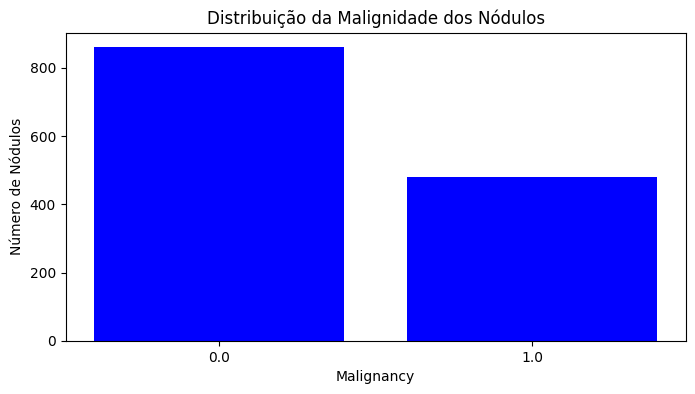

In [137]:
counts = df_nodules['malignancy_bin'].value_counts().sort_index() 
labels = counts.index.astype(str)  
plt.figure(figsize=(8,4))
plt.bar(labels, counts, color='blue')
plt.xlabel('Malignancy')
plt.ylabel('Número de Nódulos')
plt.title('Distribuição da Malignidade dos Nódulos')
plt.show()

In [138]:
contagem_valores = df_nodules['malignancy_bin'].value_counts()
contagem_valores

0.0    860
1.0    480
Name: malignancy_bin, dtype: int64

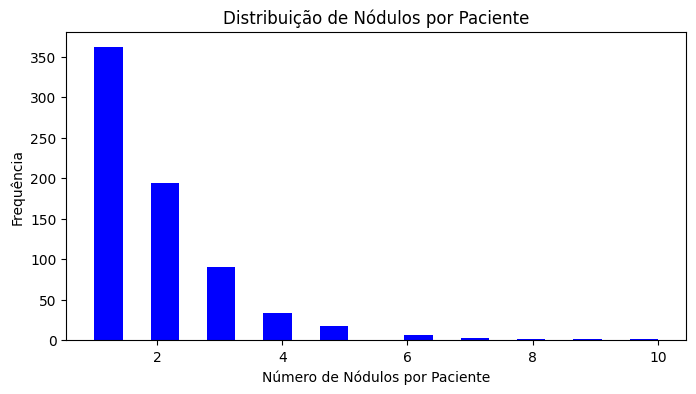

In [139]:
nodules_per_patient = df_nodules.groupby("patient_id")["nodule_id"].count()
plt.figure(figsize=(8,4))
plt.hist(nodules_per_patient, bins=20, color="blue")
plt.xlabel("Número de Nódulos por Paciente")
plt.ylabel("Frequência")
plt.title("Distribuição de Nódulos por Paciente")
plt.show()


In [140]:
nodules_per_patient.describe()


count    711.000000
mean       1.884669
std        1.258516
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       10.000000
Name: nodule_id, dtype: float64

## 2-Pré-processamento de Imagens
O pré-processamento de imagens é **fundamental** para a tarefa de classificação de cancro de pulmão. 
Devido à complexidade e variabilidade dos dados de tomografia computadorizada (CT), é preciso preparar as imagens de forma que características relevantes possam ser extraídas de maneira eficaz.
Esta preparação é especialmente importante para métodos baseados em **radiomics**, onde pequenas variações de intensidade ou textura podem ter um impacto significativo nos resultados.

### 2.1 - Compreensão e Criação de Funções Úteis para Exploração dos Dados
Antes de extrair features radiômicas, é importante entender alguns conceitos fundamentais e criar funções auxiliares que facilitem a exploração e análise das imagens.

#### Hounsfield Units (HU)
- **Definição:** *Hounsfield Units* são uma **escala numérica padronizada** que representa a densidade dos tecidos corporais em tomografias computadorizadas.  


**Importância clínica e técnica:**  
- Permite diferenciar tecidos com base na sua densidade física, o que é essencial na caracterização de nódulos pulmonares.  
- Garante que as medições de intensidade possam ser comparadas entre diferentes estudos e equipamentos, algo indispensável na análise radiômica.  
- As *features* de primeira ordem, como média, desvio padrão e entropia de intensidade, dependem diretamente da correção adequada dos valores de HU.

- Em alguns exames, os metadados que definem os parâmetros de calibração — *RescaleIntercept* e *RescaleSlope* — estavam ausentes. Nestes casos, aplicaram-se **valores padrão** amplamente aceites na literatura:
  - `intercept = -1024`  
  - `slope = 1`

- A conversão para HU foi então realizada segundo a relação:

$[
HU = pixel\_value \times slope + intercept
]$

**Justificação:**  
- O intervalo [-1000, 400] cobre as densidades típicas do tecido pulmonar, tecidos moles e lesões.  
- A exclusão de valores fora desse intervaloremove artefactos provenientes de estruturas ósseas, ar extrapulmonar e ruído, dando uma maior estabilidade nas features de intensidade.  

**Nota:** Para compreender a distribuição dos valores de HU e testar as funções de pré-processamento, escolhemos um paciente **aleatório** do dataset consolidado.  

In [141]:
scans=pl.query(pl.Scan).filter(pl.Scan.patient_id == 'LIDC-IDRI-0045').all()
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == 'LIDC-IDRI-0045').first()
print(scan)

Scan(id=56,patient_id=LIDC-IDRI-0045)


In [142]:
# Carregar a primeira fatia DICOM (image)
image = scan.load_all_dicom_images()[0]

Loading dicom files ... This may take a moment.


In [143]:
# Função para converter valores de pixel para Hounsfield Units (HU)
def convert_to_hu(image, scan):
 # Aceder a Rescale Intercept e Rescale Slope
 intercept = getattr(scan, 'slice_intercept', -1024) #valor típico usado quando o metadado não está disponível
 slope = getattr(scan, 'slice_slope', 1) #fator de escala padrão
 
 # Aplicar a fórmula de conversão
 hu_image = (image * slope) + intercept
 hu_image = np.clip(hu_image, -1000, 400) # Limitar a faixa de HU
 return hu_image

***Nota***: limitamos a faixa útil de HU pois é equivalente à janela pulmonar padrão usada em radiologia torácica.

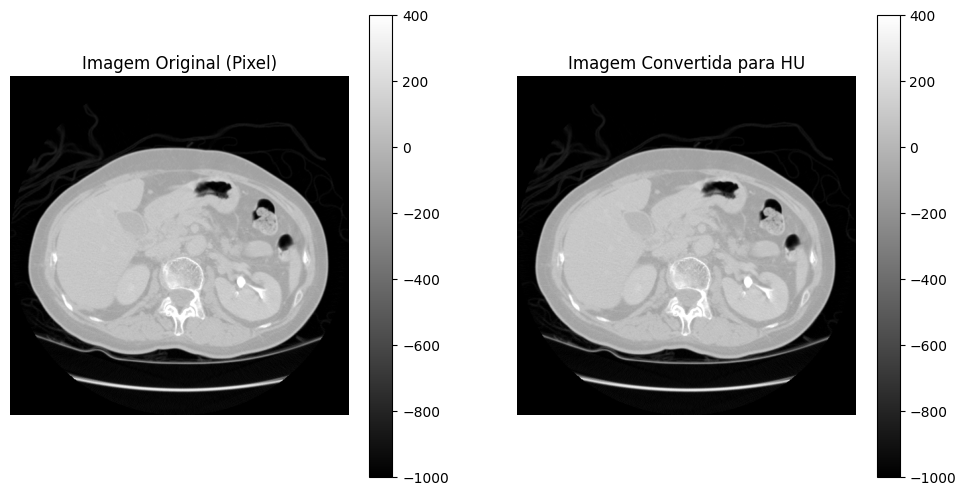

In [144]:
# Obter a imagem original (valores de pixel)
pixel_image = image.pixel_array

# Testar a função de conversão para HU
hu_image = convert_to_hu(image.pixel_array, scan)


fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Imagem original (pixels)
axes[0].imshow(pixel_image, cmap='gray')
axes[0].set_title('Imagem Original (Pixel)')
# Imagem convertida para HU
axes[1].imshow(hu_image, cmap='gray')
axes[1].set_title('Imagem Convertida para HU')
for ax in axes:
 ax.axis('off')
 plt.colorbar(ax.imshow(hu_image, cmap='gray'), ax=ax)
plt.show()

### 2.2. — Segmentação 2D do Nódulo  

A segmentação consiste em **isolar o nódulo pulmonar** do restante tecido, criando uma **máscara binária (1 = nódulo, 0 = fundo)** que define a região de interesse(ROI) a ser analisada.  

#### **Estratégia aplicada:**  
- Foi utilizada **segmentação 2D** baseada no **centroide do nódulo**, obtido a partir das anotações dos radiologistas.  
- Selecionou-se a **slice axial correspondente ao centroide** e criou-se uma máscara binária a partir das coordenadas de contorno do nódulo.  
- A imagem original e a máscara foram retornadas em pares `(imagem_slice, mascara_binaria)` para uso futuro na extração de *features*.  

#### **Justificação da escolha 2D:**  
- A abordagem 2D reduz o custo computacional, mantendo informações representativas da morfologia do nódulo.  
- É adequada para **estudos exploratórios** e protótipos de pipelines radiômicos, onde o objetivo é entender o comportamento das *features* antes de avançar para 3D.  

In [ ]:
#devolve a imagem e a máscara a serem usadas num determinado nódulo
def segmentacao_2d(scan, annotation):
    volume = scan.to_volume()

    # Obter o centro do nódulo (i, j, k) - k é a slice correspondente ao centro
    i, j, k = annotation.centroid
    slice_idx = int(k) # Convertendo k para índice da slice

    # Gerar a máscara binária para a slice correspondente
    mascara_binaria = np.zeros(volume[:, :, slice_idx].shape, dtype=np.uint8)

     # Itera sobre todos os contornos desenhados pelos radiologistas
    for contour in annotation.contours:
        if contour.image_k_position == slice_idx: # Verifica se o contorno pertence à slice onde está o centro do nódulo
            # Obter as coordenadas do contorno e convertê-las em 2D
            ii, jj = contour.to_matrix(include_k=False).T.astype(int)
            # preenche a ROI como polígono (linhas = ii, colunas = jj)
            rr, cc = polygon(ii, jj, mascara_binaria.shape)
            mascara_binaria[rr, cc] = 1
            
    # Aplicar a máscara na imagem original da slice
    imagem_slice = volume[:, :, slice_idx]
    
    return imagem_slice, mascara_binaria

Loading dicom files ... This may take a moment.


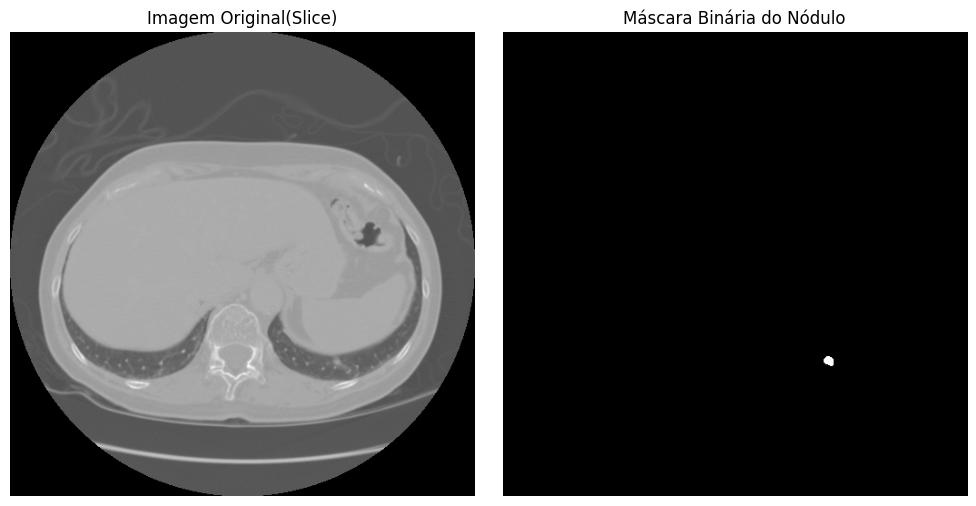

In [146]:
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == 'LIDC-IDRI-0045').first()
annotation = scan.annotations[0]

# Chama a função para processar cada nódulo
imagem, mascara = segmentacao_2d(scan, annotation)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Mostrar a imagem original no primeiro eixo
axes[0].imshow(imagem, cmap='gray')
axes[0].set_title('Imagem Original(Slice)')
axes[0].axis('off') # Esconder os eixos

# Mostrar a máscara binária no segundo eixo
axes[1].imshow(mascara, cmap='gray')
axes[1].set_title('Máscara Binária do Nódulo')
axes[1].axis('off') 

plt.tight_layout()
plt.show()


### 2.3.- Segmentação 3D

A segmentação 3D tem o objetivo de reconstruir o volume completo do nódulo, registrando a sua forma, extensão e texturas em todas as slices da tomografia.  
Ao contrário da abordagem 2D, esta etapa utiliza **todas as slices onde o nódulo foi identificado pelos radiologistas**, permitindo obter uma **máscara volumétrica tridimensional**.

#### Estratégia aplicada
- Foi utilizada a informação de **todos os contornos** presentes nas anotações radiológicas.
- Para cada contorno, identificou-se a **slice axial correspondente** através da coordenada **z**(*image_z_position*).
- As máscaras binárias foram combinadas num único volume 3D (`mascara_binaria_3d`), onde:
  - **1** representa o nódulo,
  - **0** representa o fundo.

O processo produz simultaneamente:
- a **imagem volumétrica original** (tomografia em escala HU),  
- a **máscara 3D correspondente**, necessária para a extração precisa das *features radiômicas*.


#### Justificação da abordagem 3D
- A reconstrução tridimensional fornece uma **representação completa da forma e volume** do nódulo.
- Permite extrair **features radiômicas volumétricas**.
- A abordagem 3D **reduz a perda de informação** provocada pela escolha de uma única slice.
- É particularmente importante em análises radiômicas e modelagem de malignidade, onde a **morfologia completa** do nódulo pode ser crucial.

In [147]:
#devolve o volume 3d e a máscara 3d do nódulo.
def segmentacao_3d(scan, annotation):
 
    # Obter o volume completo do scan em HU
    volume = scan.to_volume()

    # Obter os limites de cada fatia do contorno
    mascara_binaria_3d = np.zeros(volume.shape, dtype=np.uint8) #dtype=np.uint8 -> tipo inteiro pequeno (0 ou 1)

    # Iterar sobre os contornos e preencher a máscara 3D
    for contour in annotation.contours:
        # Encontra o índice da slice correspondente à posição Z do contorno
        # Usa-se np.argmin(np.abs(...)) para encontrar a slice cuja Z é mais próxima da do contorno
        slice_idx = np.argmin(np.abs(scan.slice_zvals - contour.image_z_position))

        # Obter as coordenadas 2D(i,j) do contorno na slice atual
        ii, jj = contour.to_matrix(include_k=False).T 
        mascara_binaria_3d[ii.astype(int), jj.astype(int), slice_idx] = 1 # Marca 1 nos pontos do contorno do nódulo

    return volume, mascara_binaria_3d

Loading dicom files ... This may take a moment.


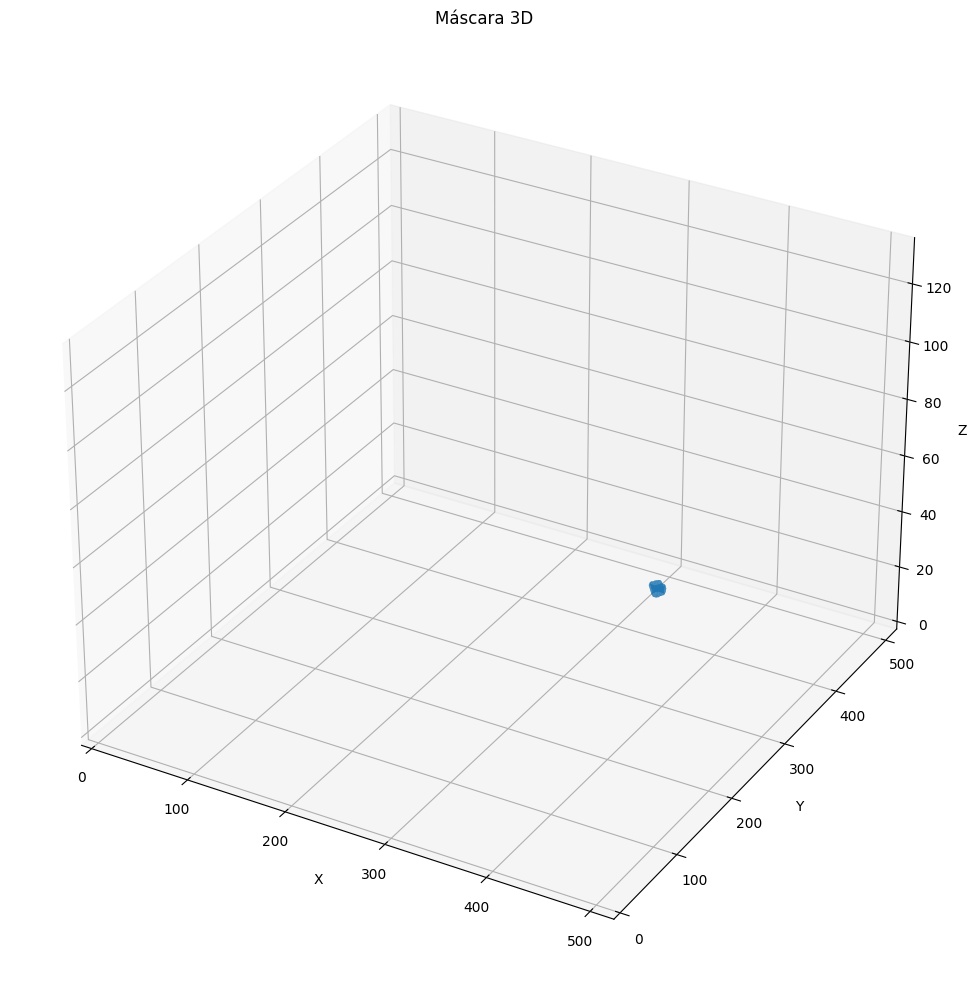

In [148]:
scans = pl.query(pl.Scan).filter(pl.Scan.patient_id == 'LIDC-IDRI-0045').all()[0]
annotations = scan.annotations
_, mascara_3d = segmentacao_3d(scan, annotation)

# Encontrar a superfície da máscara binária usando marching cubes
verts, faces, _, _ = measure.marching_cubes(mascara_3d, level=0)

# Criar a figura e o eixo 3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Renderizar a superfície 3D da máscara
mesh = Poly3DCollection(verts[faces], alpha=0.7)
ax.add_collection3d(mesh)

# Definir os limites do gráfico
ax.set_xlim(0, mascara_3d.shape[0])
ax.set_ylim(0, mascara_3d.shape[1])
ax.set_zlim(0, mascara_3d.shape[2])

# Ajustar a visualização
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Máscara 3D")
plt.tight_layout()
plt.show()

## 3 — Extração das *Features 2D* com **PyRadiomics**

Após a conversão das imagens para a escala **Hounsfield Units (HU)** e a **segmentação 2D** dos nódulos pulmonares, foi realizada a extração de *features radiômicas* utilizando o pacote **pyradiomics** — uma das bibliotecas mais utilizadas em estudos clínicos e pipelines de *radiomics*.


### Objetivo

O objetivo é **quantificar propriedades estatísticas, texturais e geométricas** dos nódulos pulmonares, transformando as imagens médicas em **descritores numéricos interpretáveis** por algoritmos de *machine learning*.

Cada *feature* representa uma característica específica do nódulo, tal como:

- **Intensidade e variação de densidade** (*First Order Features*);
- **Textura e heterogeneidade** (*GLCM*, *GLRLM*, *GLSZM*, *GLDM*, *NGTDM*);
- **Forma e geometria** (*Shape2D*).


### Processo de Extração

Para cada paciente e nódulo identificados no dataset consolidado:

1. Selecionou-se a **slice axial correspondente ao centroide** do nódulo.  
2. Gerou-se uma **máscara binária preenchida** (`0 = fundo`, `1 = nódulo`) representando a Região de Interesse (ROI).  
3. A imagem foi convertida para **escala HU**, proveniente do *pylidc*, e limitada ao intervalo **[-1000, 400]** — correspondente à **janela pulmonar padrão**.  
4. A imagem e a máscara foram convertidas para o formato **SimpleITK.Image**, mantendo a correspondência espacial entre voxels.  
5. As *features radiômicas* foram extraídas através do objeto *RadiomicsFeatureExtractor* do pacote **PyRadiomics**, com parâmetros definidos para reprodutibilidade e compatibilidade com o padrão **IBSI (Image Biomarker Standardization Initiative)**.


### Considerações Técnicas

- As imagens foram mantidas na **escala HU original**, garantindo consistência física entre diferentes exames.  
- Os valores foram limitados ao intervalo **[-1000, 400 HU]**, que abrange tecidos pulmonares, ar e estruturas ósseas leves.   


### Importância desta Etapa

A **extração de *features radiômicas*** é o ponto central do *pipeline* de análise radiômica, pois transforma imagens médicas complexas em **dados quantitativos reprodutíveis**.

Essas *features* permitem:

- **Caracterizar a heterogeneidade intratumoral**, geralmente associada à malignidade e agressividade do tumor;  
- **Minimizar a subjetividade** presente na avaliação radiológica humana;  
- **Fornecer entrada quantitativa** para modelos de *machine learning* capazes de distinguir entre nódulos benignos e malignos.

In [149]:
df=df_nodules
patient_dict = df.groupby('patient_id')['nodule_id'].apply(lambda x: list(set(x))).to_dict()

In [150]:
extractor_2d = featureextractor.RadiomicsFeatureExtractor() # inicializa extractor padrão do pyradiomics
extractor_2d.disableAllFeatures() # desativa todas as features por padrão

#ativar as classes principais de features
extractor_2d.enableFeatureClassByName('firstorder')  # estatísticas de intensidade (média, desvio padrão, etc.)
extractor_2d.enableFeatureClassByName('glcm') #matriz de coocorrência de níveis de cinzento (textura local)
extractor_2d.enableFeatureClassByName('glrlm') #matriz de comprimento de run (padrões lineares de intensidade)
extractor_2d.enableFeatureClassByName('glszm') #matriz de zonas de tamanho igual (homogeneidade regional)
extractor_2d.enableFeatureClassByName('gldm') #matriz de dependência de nível de cinzento (complexidade local)
extractor_2d.enableFeatureClassByName('ngtdm') #matriz de diferença de tons de cinzento vizinhos (variação de textura)
extractor_2d.enableFeatureClassByName('shape2D') #features geométricas 2D (área, perímetro, circularidade, etc.)

# Configurações padronizadas IBSI (CT HU)
extractor_2d.settings['resampledPixelSpacing'] = [1, 1]      # resolução isotrópica 2D
extractor_2d.settings['interpolator'] = sitk.sitkBSpline
extractor_2d.settings['resegmentRange'] = [-1000, 400]       # windowing pulmonar
extractor_2d.settings['resegmentMode'] = 'absolute'
extractor_2d.settings['binWidth'] = 25                       # discretização HU
extractor_2d.settings['normalize'] = False                   # não aplicar z-score por imagem
extractor_2d.settings['padDistance'] = 5                     # opcional: evita corte na borda
extractor_2d.settings['preCrop'] = True                      # acelera processamento

In [148]:
def processar_pacientes(patient_dict, extractor):
    feature_list = []
    
    #itera pelos pacientes definidos no dicionário
    for patient_id in patient_dict:
        print(patient_id)

        #obtem todos os scans por paciente
        scans = pl.query(pl.Scan).filter(pl.Scan.patient_id == patient_id).all()

        for _, scan in enumerate(scans): #percorre cada scan do paciente
            #obtem todas as anotações para esse scan
            annotations = scan.annotations

            # percorre os nodulos deste scan
            for nodule_idx, annotation in enumerate(annotations):
                if nodule_idx + 1 in patient_dict[patient_id]: 
                    #chama a função para processar cada nódulo
                    imagem, mascara = segmentacao_2d(scan, annotation)

                    # Idealmente, aplicar a tua convert_to_hu(...) que usa slope/intercept reais.
                    # Converter a imagem para unidades HU
                    imagem_hu = convert_to_hu(imagem, scan)
                    
                    #converter a imagem e a máscara para SimpleITK(necessário para pyradiomics)
                    imagem_sitk = sitk.GetImageFromArray(imagem_hu)
                    mascara_sitk = sitk.GetImageFromArray(mascara.astype(np.uint8))
                    
                    # Extrair as features radiômicas 
                    features = extractor.execute(imagem_sitk, mascara_sitk)
    
                    feature_dict = dict(features)
                    
                    # Adicionar o ID do paciente e o ID do nódulo ao dicionário 
                    feature_dict['patient_id'] = patient_id
                    feature_dict['nodule_id'] = nodule_idx + 1
                    
                    #guarda as features deste nodulo
                    feature_list.append(feature_dict)

    # Converter a lista de dicionários em um DataFrame do pandas
    df_features = pd.DataFrame(feature_list)
    
    # guarda o DataFrame em um arquivo CSV com codificação UTF-8
    df_features.to_csv('radiomics_features.csv', index=False, encoding='utf-8')
    
    return df_features
result_features = processar_pacientes(patient_dict, extractor_2d)

LIDC-IDRI-0001
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0002
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0003
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0004
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0005
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0006
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0007
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0008
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0009
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0010
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0011
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0012
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0013
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0014
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0015
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0016
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0017
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0018
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0020
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0021
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0022
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0023
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0024
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0025
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0026
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0027
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0029
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0031
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0033
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0034
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0036
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0037
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0039
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0041
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0042
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0043
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0044
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0045
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0046
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0047
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0048
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0049
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0050
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0051
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0052
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0053
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0054
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0055
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0056
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0057
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0058
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0059
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0060
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0061
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0063
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0064
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0066
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0067
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0068
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0069
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0070
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0072
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0073
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0074
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0075
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0076
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0077
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0078
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0080
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0081
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0082
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0083
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0084
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0085
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0086
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0087
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0088
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0089
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0090
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0091
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0092
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0093
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0094
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0095
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0096
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0098
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0099
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0101
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0103
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0104
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0106
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0107
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0108
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0111
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0112
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0116
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0117
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0118
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0119
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0120
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0121
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0123
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0124
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0125
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0126
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0127
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0128
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0129
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0130
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0131
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0134
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0135
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0136
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0137
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0138
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0139
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0141
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0142
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0144
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0145
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0146
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0147
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0148
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0149
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0150
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0152
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0153
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0154
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0156
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0157
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0158
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0159
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0160
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0161
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0162
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0163
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0164
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0166
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0167
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0168
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0170
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0171
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0172
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0173
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0176
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0178
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0179
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0181
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0182
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0183
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0184
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0185
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0186
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0187
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0188
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0190
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0191
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0192
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0193
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0194
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0195
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0196
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0198
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0199
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0200
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0201
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0203
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0204
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0206
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0207
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0209
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0211
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0212
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0213
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0215
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0216
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0217
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0219
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0220
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0221
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0222
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0223
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0228
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0229
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0231
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0233
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0235
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0236
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0240
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0241
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0242
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0243
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0244
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0246
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0248
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0249
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0250
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0252
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0254
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0255
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0256
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0257
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0259
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0260
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0262
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0263
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0265
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0266
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0267
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0268
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0270
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0271
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0272
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0273
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0275
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0276
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0277
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0280
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0281
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0284
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0285
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0286
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0287
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0288
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0289
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0290
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0291
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0292
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0294
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0296
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0297
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0298
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0299
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0300
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0301
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0304
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0305
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0308
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0309
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0311
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0312
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0313
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0314
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0317
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0318
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0321
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0323
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0325
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0326
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0334
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0335
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0337
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0339
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0340
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0341
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0343
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0344
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0345
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0346
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0347
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0348
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0351
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0352
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0353
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0354
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0356
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0357
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0358
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0359
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0360
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0362
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0363
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0366
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0367
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0368
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0369
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0370
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0371
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0374
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0375
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0376
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0377
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0379
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0380
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0381
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0384
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0385
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0386
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0387
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0388
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0390
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0392
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0393
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0394
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0395
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0396
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0398
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0399
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0400
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0402
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0403
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0404
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0405
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0406
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0407
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0408
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0409
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0411
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0412
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0413
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0414
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0415
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0419
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0420
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0421
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0423
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0424
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0426
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0427
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0430
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0431
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0432
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0433
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0435
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0436
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0437
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0439
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0440
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0443
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0444
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0445
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0447
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0448
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0450
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0451
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0452
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0453
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0454
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0456
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0459
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0460
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0461
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0462
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0463
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0464
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0466
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0467
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0468
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0469
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0470
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0471
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0473
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0474
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0476
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0477
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0478
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0479
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0480
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0481
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0483
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0485
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0486
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0487
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0488
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0489
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0490
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0491
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0492
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0494
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0495
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0496
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0497
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0499
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0504
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0507
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0508
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0509
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0510
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0515
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0516
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0518
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0520
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0521
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0523
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0524
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0525
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0526
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0527
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0529
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0530
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0532
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0533
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0534
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0535
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0537
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0538
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0541
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0542
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0543
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0545
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0546
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0547
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0549
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0550
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0552
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0559
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0562
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0565
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0566
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0567
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0568
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0569
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0571
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0572
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0575
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0576
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0577
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0578
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0579
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0581
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0582
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0583
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0586
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0587
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0588
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0590
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0594
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0595
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0596
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0597
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0598
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0599
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0601
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0602
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0604
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0605
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0606
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0607
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0608
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0609
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0610
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0613
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0614
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0615
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0617
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0619
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0620
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0621
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0624
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0625
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0626
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0628
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0630
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0635
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0636
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0637
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0639
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0640
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0641
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0642
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0643
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0644
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0645
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0647
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0648
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0649
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0650
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0651
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0655
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0657
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0660
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0661
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0662
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0663
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0664
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0666
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0669
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0670
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0671
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0672
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0673
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0674
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0677
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0678
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0680
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0682
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0686
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0687
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0688
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0693
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0695
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0696
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0697
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0698
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0700
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0701
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0702
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0703
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0704
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0705
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0706
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0707
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0709
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0713
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0715
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0717
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0719
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0720
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0721
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0722
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0724
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0725
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0726
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0727
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0729
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0730
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0732
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0733
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0734
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0735
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0740
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0741
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0742
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0743
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0747
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0748
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0749
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0750
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0751
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0754
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0756
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0757
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0759
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0761
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0762
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0765
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0767
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0768
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0770
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0771
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0772
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0773
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0775
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0776
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0777
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0780
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0782
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0783
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0785
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0786
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0787
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0788
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0789
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0790
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0791
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0792
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0793
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0794
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0795
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0796
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0797
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0798
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0799
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0800
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0801
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0802
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0805
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0806
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0807
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0810
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0811
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0812
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0813
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0814
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0815
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0817
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0818
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0819
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0822
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0823
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0824
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0825
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0826
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0827
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0828
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0829
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0830
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0831
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0832
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0834
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0835
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0836
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0837
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0838
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0840
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0841
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0842
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0843
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0845
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0846
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0849
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0850
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0851
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0852
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0854
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0855
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0856
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0857
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0858
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0860
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0861
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0863
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0864
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0865
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0866
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0867
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0868
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0869
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0870
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0871
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0872
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0873
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0874
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0875
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0879
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0882
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0883
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0884
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0886
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0890
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0892
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0893
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0894
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0895
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0896
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0898
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0899
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0902
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0904
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0905
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0906
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0907
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0908
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0910
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0911
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0912
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0913
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0914
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0916
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0917
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0919
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0920
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0921
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0922
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0923
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0924
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0925
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0928
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0929
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0932
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0933
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0935
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0936
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0938
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0939
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0940
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0942
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0944
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0946
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0947
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0949
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0950
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0951
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0955
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0956
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0957
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0959
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0961
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0962
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0963
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0965
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0966
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0968
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0972
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0973
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0976
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0978
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0980
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0981
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0982
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0985
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0987
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0993
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0994
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0996
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0997
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0998
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0999
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-1000
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-1001
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-1002
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-1003
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-1004
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-1005
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-1006
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-1007
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-1008
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-1009
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-1010
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-1011
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-1012
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


In [151]:
df_2d = pd.read_csv('radiomics_features.csv')
print("Total de features extraídas:", df_2d.shape[1])
print("Features com NaN:", df_2d.isna().sum().sum())


Total de features extraídas: 151
Features com NaN: 0


In [152]:
df_2d.head()

,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,...,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,patient_id,nodule_id
0,v3.1.0,1.21.6,2.2.1,1.3.0,3.7.9,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},6a4838357bc6f2d070314113e53ad10a6773983d,2D,"(1.0, 1.0)",...,0.110768,1.647026,0.023438,6.440554,0.010704,12.437651,0.040863,0.421775,LIDC-IDRI-0001,1
1,v3.1.0,1.21.6,2.2.1,1.3.0,3.7.9,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},449ab6385a4d56b24b85267a6582dcb52f817a58,2D,"(1.0, 1.0)",...,0.014487,0.014487,0.014487,0.000000,1000000.000000,0.000000,0.000000,0.000000,LIDC-IDRI-0002,1
2,v3.1.0,1.21.6,2.2.1,1.3.0,3.7.9,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},edfba81cb31657af3253f1a41ac507b37463ba44,2D,"(1.0, 1.0)",...,0.040369,0.430143,0.019135,2.012728,0.035918,4.692139,0.001823,4.405597,LIDC-IDRI-0003,1
3,v3.1.0,1.21.6,2.2.1,1.3.0,3.7.9,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},e690ec733adecd1b08ae397a5d1b54da427c1eb2,2D,"(1.0, 1.0)",...,0.018906,0.018906,0.018906,0.000000,1000000.000000,0.000000,0.000000,0.000000,LIDC-IDRI-0003,2
4,v3.1.0,1.21.6,2.2.1,1.3.0,3.7.9,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},155ae61b240d8d9aa62de12ed6eebdb53313af53,2D,"(1.0, 1.0)",...,0.016570,0.016570,0.016570,0.000000,1000000.000000,0.000000,0.000000,0.000000,LIDC-IDRI-0003,3


#### **3.1 Remoçao de colunas invariantes:** 
Foram removidas todas as colunas com **apenas um valor único**. Essas variáveis não contribuem para o modelo e apenas introduzem ruído estatístico.


In [153]:
# Variavel que guarda as colunas com valores unicos
value_counts = df_2d.nunique()
value_counts

diagnostics_Versions_PyRadiomics      1
diagnostics_Versions_Numpy            1
diagnostics_Versions_SimpleITK        1
diagnostics_Versions_PyWavelet        1
diagnostics_Versions_Python           1
                                   ... 
original_ngtdm_Complexity           767
original_ngtdm_Contrast             768
original_ngtdm_Strength             728
patient_id                          711
nodule_id                            12
Length: 151, dtype: int64

In [154]:
# Remoção das colunas com valores unicos
colunas_remover = value_counts[value_counts == 1].index
print(colunas_remover)
df_2d.drop(columns = colunas_remover, inplace = True)

Index(['diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy',
       'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet',
       'diagnostics_Versions_Python', 'diagnostics_Configuration_Settings',
       'diagnostics_Configuration_EnabledImageTypes',
       'diagnostics_Image-original_Dimensionality',
       'diagnostics_Image-original_Spacing', 'diagnostics_Image-original_Size',
       'diagnostics_Image-original_Minimum',
       'diagnostics_Mask-original_Spacing', 'diagnostics_Mask-original_Size',
       'diagnostics_Image-interpolated_Spacing',
       'diagnostics_Image-interpolated_Minimum',
       'diagnostics_Mask-interpolated_Spacing',
       'diagnostics_Mask-interpolated_Minimum',
       'diagnostics_Mask-resegmented_Spacing',
       'diagnostics_Mask-resegmented_Minimum', 'original_firstorder_Minimum'],
      dtype='object')


In [155]:
df_2d.shape

(1340, 131)

#### **3.2. Análise de proporção de zeros:** 
Segundo recomendações de estudos radiomicos, *features* com **>=95% de valores iguais a zero** foram removidas, pois não contêm variação suficiente para distinguir padrões entre classes.

In [156]:
#verificar porporçao de zeros por coluna
zero_ratio = (df_2d == 0).sum() / len(df_2d)
zero_ratio.sort_values(ascending=False).head(10)


original_firstorder_InterquartileRange             0.673134
original_firstorder_RobustMeanAbsoluteDeviation    0.527612
original_glrlm_GrayLevelVariance                   0.427612
original_glszm_GrayLevelVariance                   0.427612
original_glcm_ClusterProminence                    0.427612
original_glcm_ClusterShade                         0.427612
original_glszm_ZoneVariance                        0.427612
original_glcm_ClusterTendency                      0.427612
original_glcm_DifferenceAverage                    0.427612
original_gldm_GrayLevelVariance                    0.427612
dtype: float64

#### **3.3. Verificação de colunas quase constantes:** 
Variáveis com **>=99% dos valores idênticos** foram também excluídas, uma vez que não apresentam variabilidade significativa.  
Este passo elimina redundâncias provenientes de *features* com baixo contraste ou baixo dinamismo estatístico.

In [157]:
# Verificar colunas quase constantes (>=99% dos valores iguais)
quase_constantes = []
for col in df_2d.select_dtypes(include=[np.number]).columns:
    freq_max = df_2d[col].value_counts(normalize=True, dropna=False).max()
    if freq_max >= 0.99:
        quase_constantes.append(col)

print(f"Encontradas {len(quase_constantes)} colunas quase constantes (≥99% dos valores iguais).")
if quase_constantes:
    print("Exemplos:")
    print(quase_constantes[:10])


Encontradas 4 colunas quase constantes (≥99% dos valores iguais).
Exemplos:
['diagnostics_Mask-original_VolumeNum', 'diagnostics_Mask-interpolated_VolumeNum', 'diagnostics_Mask-resegmented_VolumeNum', 'original_firstorder_10Percentile']


In [158]:
df_2d = df_2d.drop(columns=quase_constantes)

**Nota:** O limiar de 99% foi utilizado por ser um valor comum para identificar features quase constantes. Este critério permite eliminar variáveis com variância muito baixa, que não trazem informação útil para o modelo, sem remover colunas que ainda apresentem alguma variação relevante.

#### **3.5. Análise de redundância entre features por correlação:** 
Para evitar multicolinearidade, calculou-se a **matriz de correlação de Pearson (|r|)** entre as *features* numéricas.  
- *Features* com **|r| > 0.95** foram consideradas redundantes.  
- De cada par altamente correlacionado, apenas uma variável foi mantida.

In [159]:
#Analisar redundância por alta correlação

# Selecionar apenas colunas numéricas
num_feats = df_2d.select_dtypes(include=[np.number])

# Calcular correlação absoluta
corr = num_feats.corr().abs()

# Considerar apenas a metade superior da matriz (evita duplicações)
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Definir limiar
thr = 0.95

# Encontrar colunas com alguma correlação acima do limiar
to_drop_corr = [col for col in upper.columns if any(upper[col] > thr)]

if len(to_drop_corr) > 0:
    print(f"Existem {len(to_drop_corr)} features com |r| > {thr}")
    print("As 20 primeiras são:")
    print(to_drop_corr[:20])
else:
    print("Nenhuma correlação excessiva detectada.")

Existem 62 features com |r| > 0.95
As 20 primeiras são:
['diagnostics_Mask-interpolated_VoxelNum', 'diagnostics_Mask-resegmented_VoxelNum', 'diagnostics_Mask-resegmented_Mean', 'diagnostics_Mask-resegmented_Maximum', 'original_shape2D_MaximumDiameter', 'original_shape2D_MeshSurface', 'original_shape2D_MinorAxisLength', 'original_shape2D_Perimeter', 'original_shape2D_PixelSurface', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_InterquartileRange', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity']


In [160]:
cols_to_remove = set()

for i in range(len(corr.columns)):
    for j in range(i):
        if corr.iloc[i, j] > thr:
            colname = corr.columns[i]
            cols_to_remove.add(colname)

print(f"Total de features redundantes: {len(cols_to_remove)}")
print(list(cols_to_remove)[:20])

# Remover as colunas redundantes
df_2d = df_2d.drop(columns=list(cols_to_remove))

Total de features redundantes: 62
['original_shape2D_MinorAxisLength', 'original_glcm_SumSquares', 'original_glrlm_GrayLevelVariance', 'original_glcm_Autocorrelation', 'original_glcm_MaximumProbability', 'original_glcm_JointAverage', 'diagnostics_Mask-resegmented_Maximum', 'original_glrlm_RunPercentage', 'original_firstorder_Energy', 'original_firstorder_90Percentile', 'original_shape2D_MeshSurface', 'original_glrlm_HighGrayLevelRunEmphasis', 'original_firstorder_TotalEnergy', 'original_glcm_SumAverage', 'original_gldm_LargeDependenceHighGrayLevelEmphasis', 'original_glcm_DifferenceAverage', 'original_firstorder_MeanAbsoluteDeviation', 'original_gldm_LargeDependenceEmphasis', 'original_glszm_SmallAreaHighGrayLevelEmphasis', 'original_glcm_Id']


In [161]:
df_merged_2d=pd.merge(df,df_2d, on=['patient_id','nodule_id'], how='inner')

In [162]:
df_merged_2d.head()

,patient_id,nodule_id,calcification,internal_structure,spiculation,lobulation,sphericity,margin,subtlety,texture,...,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Contrast,original_ngtdm_Strength
0,LIDC-IDRI-0001,1,6,1,4.5,3.0,3.5,3.5,5.0,5.0,...,4.804073,131.989936,0.120759,5.693781,308.088747,0.023438,6.440554,0.010704,0.040863,0.421775
1,LIDC-IDRI-0002,1,6,1,1.0,1.0,4.0,1.5,1.5,1.5,...,0.931873,595.661853,0.716801,1.028824,831.000000,0.014487,0.000000,1000000.000000,0.000000,0.000000
2,LIDC-IDRI-0003,1,6,1,1.5,1.5,3.5,3.5,4.5,5.0,...,2.238492,184.996283,0.343859,3.795553,464.327138,0.019135,2.012728,0.035918,0.001823,4.405597
3,LIDC-IDRI-0003,2,6,1,1.5,1.5,4.0,4.5,4.0,5.0,...,1.869864,39.811321,0.375578,2.341047,106.000000,0.018906,0.000000,1000000.000000,0.000000,0.000000
4,LIDC-IDRI-0003,3,6,1,2.0,1.0,5.0,4.5,4.0,4.5,...,1.495247,103.784689,0.496577,1.734118,209.000000,0.016570,0.000000,1000000.000000,0.000000,0.000000


#### **3.6. Deteção e tratamento de outliers:** 
A consistência estatística das *features radiômicas* foi avaliada através da análise de *outliers* com base no **Z-score**.  
- Um valor foi considerado *outlier* se |Z| > 5, representando desvios superiores a 5 sigmas da média.  

Essas amostras foram removidas para aumentar a estabilidade estatística do *dataset*.  
Adotou-se o critério conservador de **<=5 *outliers* por amostra**, resultando na eliminação de apenas uma pequena fração de observações extremas.


In [163]:
label = "malignancy_bin"

# Selecionar apenas colunas numéricas (excluindo o label)
num_cols = df_merged_2d.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != label]

# Calcular z-scores e detetar valores > 5σ
z_scores = np.abs(zscore(df_merged_2d[num_cols], nan_policy='omit'))
outlier_counts = (z_scores > 5).sum(axis=0)
total_outliers = (z_scores > 5).any(axis=1).sum()

# Mostrar estatísticas gerais
print(f"\nAmostras com outliers (>5σ em ≥1 feature): {total_outliers}/{len(df_merged_2d)} "
      f"({100*total_outliers/len(df_merged_2d):.2f}%)")

# Top 10 features com mais outliers
outlier_features = pd.Series(outlier_counts, index=num_cols).sort_values(ascending=False)
print("\nTop 10 features com mais outliers (>5σ):")
display(outlier_features.head(10))

# Contar nº de features com outliers por amostra
df_merged_2d["n_outlier_feats"] = (z_scores > 5).sum(axis=1)

# Top 5 amostras com mais outliers
top_outlier_cases = df_merged_2d.sort_values("n_outlier_feats", ascending=False).head(10)
print("\nTop 10 amostras com mais outliers:")
display(top_outlier_cases[["patient_id", "nodule_id", "n_outlier_feats"]])


Amostras com outliers (>5σ em ≥1 feature): 127/1340 (9.48%)

Top 10 features com mais outliers (>5σ):


original_glcm_ClusterShade                     20
original_glszm_SizeZoneNonUniformity           14
original_firstorder_Median                     13
original_glrlm_LongRunHighGrayLevelEmphasis    13
original_glrlm_RunVariance                     12
original_glszm_GrayLevelNonUniformity          11
diagnostics_Mask-interpolated_Mean             10
original_glcm_Contrast                         10
num_slices                                      9
diagnostics_Image-interpolated_Mean             9
dtype: int64


Top 10 amostras com mais outliers:


,patient_id,nodule_id,n_outlier_feats
947,LIDC-IDRI-0702,1,9
1219,LIDC-IDRI-0910,1,7
662,LIDC-IDRI-0464,1,5
40,LIDC-IDRI-0022,1,5
1031,LIDC-IDRI-0772,1,5
969,LIDC-IDRI-0717,1,5
1265,LIDC-IDRI-0951,2,5
1264,LIDC-IDRI-0951,1,5
481,LIDC-IDRI-0337,1,5
112,LIDC-IDRI-0058,1,4


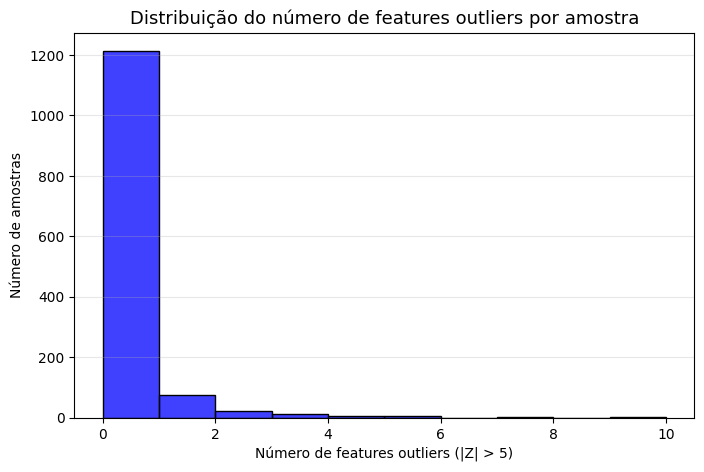

Contagem de amostras por número de features outliers:
0    1213
1      76
2      23
3      12
4       7
5       7
7       1
9       1
Name: n_outlier_feats, dtype: int64


In [164]:
# Histograma de contagem de outlier features por amostra
plt.figure(figsize=(8,5))
sns.histplot(df_merged_2d["n_outlier_feats"], bins=range(0, df_merged_2d["n_outlier_feats"].max()+2), 
             kde=False, color='blue', edgecolor='black')

plt.title("Distribuição do número de features outliers por amostra", fontsize=13)
plt.xlabel("Número de features outliers (|Z| > 5)")
plt.ylabel("Número de amostras")
plt.grid(axis='y', alpha=0.3)
plt.show()

# Estatísticas descritivas
vc = df_merged_2d["n_outlier_feats"].value_counts().sort_index()

print("Contagem de amostras por número de features outliers:")
print(vc)


In [165]:
df_merged_2d = df_merged_2d[df_merged_2d["n_outlier_feats"] <= 5].copy()

**Nota:** Adotamos o limiar <=5 outliers por amostra, eliminande apenas uma pequena parte dos casos mais extremos.

In [166]:
df_merged_2d.shape

(1338, 82)

#### **3.7. Análise de Correlação entre Features Radiômicas e a label de Malignidade**
A figura abaixo apresenta as **20 features com maior correlação (|r|)** em relação a label binária *malignancy_bin*.  
O objetivo desta análise é identificar quais **características radiômicas e morfológicas** possuem maior associação linear com a malignidade, auxiliando na interpretação e seleção de variáveis relevantes para etapas posteriores de modelagem preditiva.

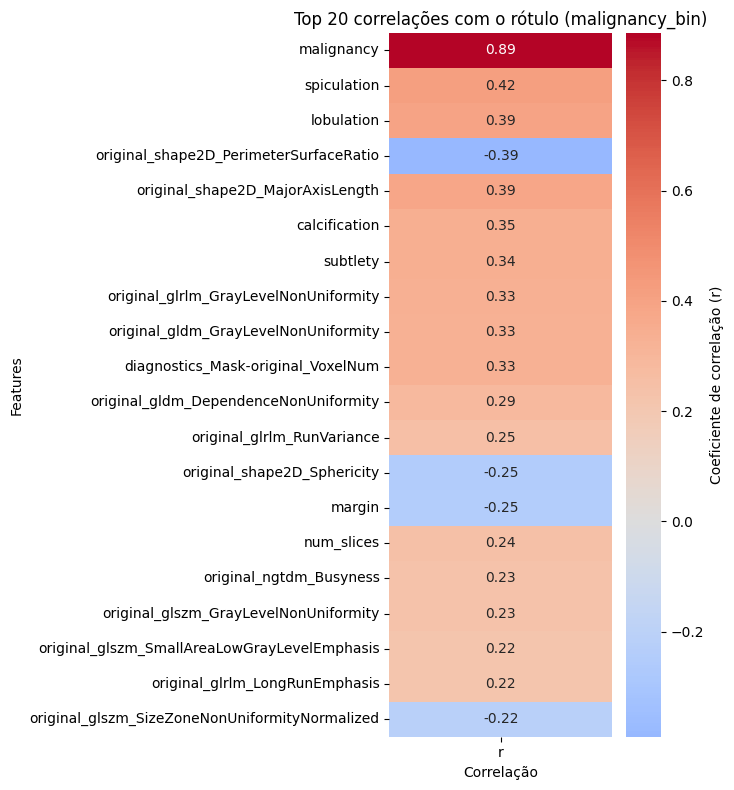

In [167]:
label = "malignancy_bin"

# Calcular correlação apenas com colunas numéricas
corr_lbl = (
    df_merged_2d.select_dtypes(include=[np.number])
    .corr()[label]
    .drop(label)
)

# Ordenar por |r| e selecionar Top-20
top = corr_lbl.reindex(corr_lbl.abs().sort_values(ascending=False).index).head(20)

# Criar heatmap vertical (altura ajustável)
plt.figure(figsize=(7, max(4, 0.4*len(top))))
sns.heatmap(
    top.to_frame(name="r"), 
    annot=True, fmt=".2f",
    cmap="coolwarm", center=0, 
    cbar_kws={"label": "Coeficiente de correlação (r)"}
)
plt.title("Top 20 correlações com o rótulo (malignancy_bin)")
plt.ylabel("Features")
plt.xlabel("Correlação")
plt.tight_layout()
plt.show()


**Observações:**

- As features **clínicas de morfologia** — *spiculation* (r = 0.42) e *lobulation* (r = 0.39) — apresentaram forte correlação positiva com o rótulo, refletindo a **associação conhecida entre irregularidade de borda e malignidade** em nódulos pulmonares.  
- A feature *calcification* (r = 0.35) manteve correlação positiva, coerente com o fato de que nódulos menos calcificados tendem a ser malignos.  
- As features **texturais** derivadas de matrizes radiômicas — como *GLRLM_GrayLevelNonUniformity* (r = 0.33) e *GLDM_GrayLevelNonUniformity* (r = 0.33) — mostraram que **heterogeneidade de intensidade** e **variação local de densidade** também se relacionam positivamente à malignidade.  
- Entre as correlações negativas, destacam-se *Shape2D_PerimeterSurfaceRatio* (r = -0.39) e *Shape2D_Sphericity* (r = -0.25), indicando que **formas menos esféricas e com maior irregularidade geométrica** tendem a estar associadas a nódulos malignos.  


**Interpretação Radiômica:** Os resultados sugerem que **combinações de parâmetros morfológicos e texturais** são bons descritores da malignidade pulmonar. A coerência entre os padrões observados e a literatura reforça a **validade do pipeline de pré-processamento e extração radiômica**, além de demonstrar a **robustez das features obtidas via PyRadiomics**.


Esta etapa exploratória é essencial para:  
- **Reduzir a dimensionalidade**, ao focar em variáveis mais informativas;  
- **Validar a coerência clínica** das features extraídas;  
- **Orientar a seleção de variáveis** para modelos de classificação e análises multivariadas subsequentes.  

#### **3.8. Criação de novas features:** vamos enriquecer *df_2d* com novas engineered features.

Para enriquecer o conjunto original, foram criadas **novas features derivadas** (*engineered features*) com base em relações conhecidas da literatura radiômica, como razões, índices de homogeneidade e métricas normalizadas.  
Estas transformações visam aumentar a robustez e reduzir dependências de escala entre as variáveis.

Principais *features* derivadas criadas:

| Grupo | *Feature* | Descrição / Fórmula |
|-------|------------|---------------------|
| **First-order** | Coeficiente de variação | `CV = Std / Mean` |
| | Densidade de energia | `EnergyDensity = Energy / Area` |
| | Uniformity over Entropy | `Uniformity / Entropy` |
| **GLCM** | `Contrast / IDM` | Relação entre contraste e momento inverso |
| | `Correlation × Homogeneity` | Combinação de textura e regularidade |
| **GLRLM** | `SRE / LRE`, `GLNU / RLNU` | Medidas de equilíbrio de *runs* curtos/longos |
| **GLSZM** | `SAE / LAE`, `SZN / GLNU2` | Proporção entre zonas pequenas e grandes |
| **GLDM / NGTDM** | `Busyness / Coarseness`, `DepVar / DepNonUniformity` | Textura dependente da granularidade |
| **Shape2D** | Circularidade | `(4π × Área) / Perímetro²` |
| | Elongation Proxy | `MaiorEixo / MenorEixo` |

Além disso, aplicaram-se **transformações logarítmicas suaves (`log1p`)** em métricas com grande amplitude dinâmica, mitigando o efeito de *outliers* e aproximando as distribuições à normalidade.

In [168]:
df_2d=df_merged_2d

In [169]:
orig_cols = set(df_2d.columns)

#Devolve a 1ª coluna existente da lista; caso nenhuma exista, devolve None
def get(colname_list): 
    for c in colname_list:
        if c in df_2d.columns:
            return c
    return None

eps = 1e-12
new_feats = {}

In [170]:
# First-order (intensidade)
c_mean = get(["original_firstorder_Mean"])
c_std  = get(["original_firstorder_StandardDeviation","original_firstorder_StdDev","original_firstorder_RMS"])  # StdDev/RMS
if c_mean and c_std:
    new_feats["eng_firstorder_CV"] = df_2d[c_std] / (df_2d[c_mean].abs() + eps)  # coeficiente de variação

c_iqr   = get(["original_firstorder_InterquartileRange"])
c_min   = get(["original_firstorder_Minimum"])
c_max   = get(["original_firstorder_Maximum"])
if c_iqr and c_min and c_max:
    new_feats["eng_firstorder_IQR_over_Range"] = df_2d[c_iqr] / ( (df_2d[c_max] - df_2d[c_min]).abs() + eps )

c_entropy = get(["original_firstorder_Entropy"])
c_uniform = get(["original_firstorder_Uniformity"])
if c_entropy and c_uniform:
    new_feats["eng_firstorder_Uniformity_over_Entropy"] = df_2d[c_uniform] / (df_2d[c_entropy].abs() + eps)

c_energy = get(["original_firstorder_Energy","original_firstorder_TotalEnergy"])
c_area   = get(["original_shape2D_PixelSurface","original_shape2D_AreaPixels"])  # nomes comuns
if c_energy and c_area:
    new_feats["eng_firstorder_EnergyDensity"] = df_2d[c_energy] / (df_2d[c_area].abs() + eps)

In [171]:
#GLCM (textura local)
c_contrast = get(["original_glcm_Contrast"])
c_idm      = get(["original_glcm_Idmn","original_glcm_Idm","original_glcm_InverseDifferenceMoment"])
if c_contrast and c_idm:
    new_feats["eng_glcm_Contrast_over_IDM"] = df_2d[c_contrast] / (df_2d[c_idm].abs() + eps)

c_corr = get(["original_glcm_Correlation"])
c_hom  = get(["original_glcm_Homogeneity","original_glcm_Idn","original_glcm_Idmn"])
if c_corr and c_hom:
    new_feats["eng_glcm_Corr_times_Homog"] = df_2d[c_corr] * df_2d[c_hom]

In [172]:
# GLRLM (runs)
c_sre = get(["original_glrlm_ShortRunEmphasis"])
c_lre = get(["original_glrlm_LongRunEmphasis"])
if c_sre and c_lre:
    new_feats["eng_glrlm_SRE_over_LRE"] = df_2d[c_sre] / (df_2d[c_lre].abs() + eps)

c_glnu = get(["original_glrlm_GrayLevelNonUniformity","original_glrlm_GrayLevelNonUniformityNormalized"])
c_rlnu = get(["original_glrlm_RunLengthNonUniformity","original_glrlm_RunLengthNonUniformityNormalized"])
if c_glnu and c_rlnu:
    new_feats["eng_glrlm_GLNU_over_RLNU"] = df_2d[c_glnu] / (df_2d[c_rlnu].abs() + eps)

In [173]:
# GLSZM (zonas) 
c_sae = get(["original_glszm_SmallAreaEmphasis"])
c_lae = get(["original_glszm_LargeAreaEmphasis"])
if c_sae and c_lae:
    new_feats["eng_glszm_SAE_over_LAE"] = df_2d[c_sae] / (df_2d[c_lae].abs() + eps)

c_szn   = get(["original_glszm_SizeZoneNonUniformity","original_glszm_SizeZoneNonUniformityNormalized"])
c_glnu2 = get(["original_glszm_GrayLevelNonUniformity","original_glszm_GrayLevelNonUniformityNormalized"])
if c_szn and c_glnu2:
    new_feats["eng_glszm_SZN_over_GLNU"] = df_2d[c_szn] / (df_2d[c_glnu2].abs() + eps)

In [174]:
# GLDM / NGTDM 
c_bus = get(["original_ngtdm_Busyness"])
c_coa = get(["original_ngtdm_Coarseness"])
if c_bus and c_coa:
    new_feats["eng_ngtdm_Busyness_over_Coarseness"] = df_2d[c_bus] / (df_2d[c_coa].abs() + eps)
    new_feats["eng_ngtdm_InvCoarseness"] = 1.0 / (df_2d[c_coa].abs() + eps)

c_depvar = get(["original_gldm_DependenceVariance"])
c_depnon = get(["original_gldm_DependenceNonUniformity","original_gldm_DependenceNonUniformityNormalized"])
if c_depvar and c_depnon:
    new_feats["eng_gldm_DepVar_over_DepNonUni"] = df_2d[c_depvar] / (df_2d[c_depnon].abs() + eps)

In [175]:
# Forma 2D 
c_perim = get(["original_shape2D_Perimeter"])
c_area2 = get(["original_shape2D_PixelSurface","original_shape2D_AreaPixels"])
if c_area2 and c_perim:
    new_feats["eng_shape2D_Circularity"] = (4.0 * pi * df_2d[c_area2].abs()) / ( (df_2d[c_perim].abs() + eps)**2 )

c_minor = get(["original_shape2D_MinorAxisLength"])
c_maxd  = get(["original_shape2D_MaximumDiameter","original_shape2D_MajorAxisLength"])
if c_maxd and c_minor:
    new_feats["eng_shape2D_ElongationProxy"] = (df_2d[c_maxd].abs() + eps) / (df_2d[c_minor].abs() + eps)

In [176]:
# Transformações robustas (log1p) em algumas métricas “explosivas”
for cname in [
    c_energy, c_contrast, c_bus, c_depvar
]:
    if isinstance(cname, str):
        new_feats[f"eng_log1p__{cname}"] = np.log1p( df_2d[cname].clip(lower=0) )

In [177]:
#Consolidar, limpar e guardar 
df_new = pd.DataFrame(new_feats)

# Substituir infs e NaNs gerados por divisões
df_new = df_new.replace([np.inf, -np.inf], np.nan)

# Anexar ao CSV
df_out = pd.concat([df_2d, df_new], axis=1)

print(f"Novas colunas criadas: {len(df_out.columns) - len(orig_cols)}")
print("Shape antes:", df_2d.shape, " | depois:", df_out.shape)

Novas colunas criadas: 11
Shape antes: (1338, 82)  | depois: (1338, 93)


In [179]:
# Salvar o DataFrame em um arquivo CSV com codificação UTF-8
df_out.to_csv('data_2d.csv', index=False, encoding='utf-8')

## 4 — Extração das *Features 3D* com **PyRadiomics**

Após a construção do volume tridimensional do nódulo, foi feita a extração de *features* radiômicas 3D utilizando o **PyRadiomics**, permitindo uma análise volumétrica mais completa e detalhada.

### Estratégia aplicada
- As imagens e máscaras foram convertidas para o formato *SimpleITK.Image*, garantindo a correspondência espacial dos voxels (posicionamento num sistema de coordenadas 3D).
- Utilizou-se a função *segmentacao_3d()* para obter o volume em **Hounsfield Units (HU)** e a respetiva máscara volumétrica.
- As *features* foram extraídas através do objeto *RadiomicsFeatureExtractor*, configurado para incluir as principais classes radiômicas:
  - **First Order Features** — intensidade e variação de densidade;
  - **GLCM, GLRLM, GLSZM, GLDM, NGTDM** — texturas e heterogeneidade do nódulo;
  - **Shape** — forma e geometria volumétrica.

**Considerações técnicas:** Foram removidas colunas com valores únicos e dados irrelevantes para reduzir a dimensionalidade do dataset e evitar redundância.

#### Importância da abordagem 3D
- Captura a **morfologia completa** do nódulo, incluindo irregularidades que podem não ser visiveis numa única *slice*.
- Melhora a **robustez das features de textura e forma**, fundamentais para caracterizar malignidade e heterogeneidade tumoral.
- Fornece um conjunto mais abrangente de descritores quantitativos, possibilitando análises preditivas mais precisas em modelos de *machine learning*.

In [180]:
extractor_3d = featureextractor.RadiomicsFeatureExtractor()
extractor_3d.disableAllFeatures()
extractor_3d.enableFeatureClassByName('firstorder')
extractor_3d.enableFeatureClassByName('glcm')
extractor_3d.enableFeatureClassByName('glrlm')
extractor_3d.enableFeatureClassByName('glszm')
extractor_3d.enableFeatureClassByName('gldm')
extractor_3d.enableFeatureClassByName('ngtdm')
extractor_3d.enableFeatureClassByName('shape')  


# Configurações padronizadas IBSI (CT HU)
extractor_3d.settings['resampledPixelSpacing'] = [1, 1, 1]    # voxel isotrópico
extractor_3d.settings['interpolator'] = sitk.sitkBSpline
extractor_3d.settings['resegmentRange'] = [-1000, 400]        # windowing pulmonar
extractor_3d.settings['resegmentMode'] = 'absolute'
extractor_3d.settings['binWidth'] = 25                        # discretização HU
extractor_3d.settings['normalize'] = False                    # sem z-score por imagem
extractor_3d.settings['padDistance'] = 5
extractor_3d.settings['preCrop'] = True

In [365]:
def processar_pacientes_3D(patient_dict, extractor):
    feature_list = []
    
    for patient_id in patient_dict:
        print(patient_id)
        # Obter os scans por paciente
        scans = pl.query(pl.Scan).filter(pl.Scan.patient_id == patient_id).all()

        for _, scan in enumerate(scans): 
            # Obter todas as anotações (nódulos) para esse scan
            annotations = scan.annotations

            # Iterar dentro dos nódulos
            for nodule_idx, annotation in enumerate(annotations):
                if nodule_idx + 1 in patient_dict[patient_id]: 
                    # Chamar a função para processar cada nódulo
                    imagem, mascara = segmentacao_3d(scan, annotation)
                
                    # Converter a imagem para unidades HU
                    imagem_hu = convert_to_hu(imagem, scan)
                    
                    # Converter a imagem e a máscara para SimpleITK
                    imagem_sitk = sitk.GetImageFromArray(imagem_hu)
                    mascara_sitk = sitk.GetImageFromArray(mascara.astype(np.uint8))
                    
                    # Extrair as features radiômicas
                    features = extractor.execute(imagem_sitk, mascara_sitk)
    
                    feature_dict = dict(features)
                    
                    # Adicionar o ID do paciente e o ID do nódulo ao dicionário de 
                    feature_dict['patient_id'] = patient_id
                    feature_dict['nodule_id'] = nodule_idx + 1
                    
                    # Adicionar o dicionário à lista de features
                    feature_list.append(feature_dict)

    # Converter a lista de dicionários em um DataFrame do pandas
    df_features = pd.DataFrame(feature_list)
    
    # Salvar o DataFrame em um arquivo CSV com codificação UTF-8
    df_features.to_csv('radiomics_features_3D.csv', index=False, encoding='utf-8')
    
    return df_features
result_features = processar_pacientes_3D(patient_dict, extractor_3d)

LIDC-IDRI-0001
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0002
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0003
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0004
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0005
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0006
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0007
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0008
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0009
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0010
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0011
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0012
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0013
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0014
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0015
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0016
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0017
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0018
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0020
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0021
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0022
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0023
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0024
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0025
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0026
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0027
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0029
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0031
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0033
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0034
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0036
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0037
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0039
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0041
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0042
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0043
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0044
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0045
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0046
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0047
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0048
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0049
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0050
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0051
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0052
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0053
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0054
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0055
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0056
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0057
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0058
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0059
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0060
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0061
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0063
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0064
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0066
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0067
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0068
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0069
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0070
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0072
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0073
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0074
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0075
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0076
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0077
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0078
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0080
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0081
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0082
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0083
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0084
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0085
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0086
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0087
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0088
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0089
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0090
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0091
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0092
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0093
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0094
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0095
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0096
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0098
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0099
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0101
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0103
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0104
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0106
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0107
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0108
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0111
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0112
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0116
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0117
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0118
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0119
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0120
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0121
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0123
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0124
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0125
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0126
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0127
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0128
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0129
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0130
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0131
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0134
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0135
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0136
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0137
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0138
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0139
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0141
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0142
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0144
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0145
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0146
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0147
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0148
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0149
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0150
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0152
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0153
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0154
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0156
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0157
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0158
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0159
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0160
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0161
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0162
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0163
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0164
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0166
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0167
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0168
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0170
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0171
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0172
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0173
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0176
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0178
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0179
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0181
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0182
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0183
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0184
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0185
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0186
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0187
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0188
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0190
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0191
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0192
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0193
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0194
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0195
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0196
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0198
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0199
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0200
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0201
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0203
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0204
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0206
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0207
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0209
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0211
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0212
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0213
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0215
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0216
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0217
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0219
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0220
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0221
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0222
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0223
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0228
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0229
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0231
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0233
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0235
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0236
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0240
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0241
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0242
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0243
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0244
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0246
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0248
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0249
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0250
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0252
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0254
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0255
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0256
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0257
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0259
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0260
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0262
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0263
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0265
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0266
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0267
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0268
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0270
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0271
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0272
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0273
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0275
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0276
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0277
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0280
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0281
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0284
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0285
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0286
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0287
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0288
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0289
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0290
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0291
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0292
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0294
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0296
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0297
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0298
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0299
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0300
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0301
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0304
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0305
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0308
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0309
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0311
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0312
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0313
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0314
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0317
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0318
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0321
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0323
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0325
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0326
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0334
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0335
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0337
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0339
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0340
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0341
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0343
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0344
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0345
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0346
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0347
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0348
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0351
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0352
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0353
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0354
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0356
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0357
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0358
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0359
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0360
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0362
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0363
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0366
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0367
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0368
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0369
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0370
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0371
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0374
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0375
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0376
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0377
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0379
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0380
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0381
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0384
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0385
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0386
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0387
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0388
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0390
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0392
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0393
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0394
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0395
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0396
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0398
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0399
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0400
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0402
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0403
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0404
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0405
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0406
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0407
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0408
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0409
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0411
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0412
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0413
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0414
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0415
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0419
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0420
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0421
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0423
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0424
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0426
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0427
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0430
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0431
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0432
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0433
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0435
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0436
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0437
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0439
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0440
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0443
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0444
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0445
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0447
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0448
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0450
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0451
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0452
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0453
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0454
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0456
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0459
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0460
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0461
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0462
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0463
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0464
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0466
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0467
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0468
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0469
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0470
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0471
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0473
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0474
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0476
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0477
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0478
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0479
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0480
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0481
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0483
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0485
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0486
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0487
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0488
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0489
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0490
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0491
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0492
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0494
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0495
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0496
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0497
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0499
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0504
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0507
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0508
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0509
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0510
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0515
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0516
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0518
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0520
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0521
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0523
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0524
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0525
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0526
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0527
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0529
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0530
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0532
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0533
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0534
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0535
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0537
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0538
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0541
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0542
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0543
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0545
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0546
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0547
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0549
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0550
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0552
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0559
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0562
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0565
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0566
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0567
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0568
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0569
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0571
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0572
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0575
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0576
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0577
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0578
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0579
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0581
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0582
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0583
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0586
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0587
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0588
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0590
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0594
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0595
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0596
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0597
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0598
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0599
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0601
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0602
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0604
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0605
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0606
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0607
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0608
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0609
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0610
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0613
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0614
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0615
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0617
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0619
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0620
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0621
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0624
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0625
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0626
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0628
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0630
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0635
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0636
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0637
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0639
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0640
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0641
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0642
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0643
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0644
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0645
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0647
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0648
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0649
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0650
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0651
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0655
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0657
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0660
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0661
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0662
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0663
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0664
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0666
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0669
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0670
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0671
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0672
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0673
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0674
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0677
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0678
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0680
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0682
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0686
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0687
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0688
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0693
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0695
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0696
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0697
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0698
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0700
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0701
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0702
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0703
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0704
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0705
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0706
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0707
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0709
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0713
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0715
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0717
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0719
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0720
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0721
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0722
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0724
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0725
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0726
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0727
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0729
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0730
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0732
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0733
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0734
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0735
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0740
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0741
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0742
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0743
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0747
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0748
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0749
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0750
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0751
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0754
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0756
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0757
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0759
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0761
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0762
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0765
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0767
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0768
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0770
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0771
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0772
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0773
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0775
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0776
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0777
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0780
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0782
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0783
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0785
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0786
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0787
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0788
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0789
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0790
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0791
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0792
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0793
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0794
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0795
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0796
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0797
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0798
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0799
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0800
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0801
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0802
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0805
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0806
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0807
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0810
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0811
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0812
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0813
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0814
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0815
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0817
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0818
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0819
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0822
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0823
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0824
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0825
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0826
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0827
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0828
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0829
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0830
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0831
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0832
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0834
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0835
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0836
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0837
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0838
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0840
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0841
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0842
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0843
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0845
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0846
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0849
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0850
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0851
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0852
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0854
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0855
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0856
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0857
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0858
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0860
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0861
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0863
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0864
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0865
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0866
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0867
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0868
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0869
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0870
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0871
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0872
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0873
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0874
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0875
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0879
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0882
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0883
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0884
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0886
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0890
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0892
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0893
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0894
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0895
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0896
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0898
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0899
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0902
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0904
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0905
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0906
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0907
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0908
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0910
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0911
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0912
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0913
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0914
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0916
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0917
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0919
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0920
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0921
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0922
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0923
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0924
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0925
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0928
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0929
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0932
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0933
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0935
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0936
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0938
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0939
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0940
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0942
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0944
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0946
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0947
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0949
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0950
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0951
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0955
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0956
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0957
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0959
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0961
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0962
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0963
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0965
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0966
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0968
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0972
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0973
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0976
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0978
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0980
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0981
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0982
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0985
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0987
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0993
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0994
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0996
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0997
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0998
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-0999
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-1000
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-1001
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-1002
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-1003
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-1004
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-1005
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-1006
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-1007
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-1008
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-1009
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-1010
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-1011
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


LIDC-IDRI-1012
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


In [181]:
df_3d = pd.read_csv('radiomics_features_3D.csv')
print("Total de features extraídas:", df_3d.shape[1])
print("Features com NaN:", df_3d.isna().sum().sum())

Total de features extraídas: 156
Features com NaN: 0


In [182]:
df_3d.head()

,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,...,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,patient_id,nodule_id
0,v3.1.0,1.21.6,2.2.1,1.3.0,3.7.9,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},0b9beeba634aecfd62439c1850906895ec46d22b,3D,"(1.0, 1.0, 1.0)",...,0.052187,0.080941,0.048548,0.885347,0.284191,0.032596,0.000051,0.950551,LIDC-IDRI-0001,1
1,v3.1.0,1.21.6,2.2.1,1.3.0,3.7.9,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},3305c9cfd21317246fc10e01cbec381001fd545d,3D,"(1.0, 1.0, 1.0)",...,0.053507,2.029233,0.036341,3.623150,0.008515,29.207509,0.001822,14.773682,LIDC-IDRI-0002,1
2,v3.1.0,1.21.6,2.2.1,1.3.0,3.7.9,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},118a0902267d8bbe81f8da2b81af12eb7c146f0a,3D,"(1.0, 1.0, 1.0)",...,0.048407,0.133592,0.043571,1.198642,0.140084,0.284960,0.000231,4.442250,LIDC-IDRI-0003,1
3,v3.1.0,1.21.6,2.2.1,1.3.0,3.7.9,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},118a0902267d8bbe81f8da2b81af12eb7c146f0a,3D,"(1.0, 1.0, 1.0)",...,0.052858,0.052858,0.052858,0.000000,1000000.000000,0.000000,0.000000,0.000000,LIDC-IDRI-0003,2
4,v3.1.0,1.21.6,2.2.1,1.3.0,3.7.9,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},118a0902267d8bbe81f8da2b81af12eb7c146f0a,3D,"(1.0, 1.0, 1.0)",...,0.046272,0.046272,0.046272,0.000000,1000000.000000,0.000000,0.000000,0.000000,LIDC-IDRI-0003,3


In [183]:
# Variavel que guarda as colunas com valores unicos
value_counts = df_3d.nunique()
value_counts

diagnostics_Versions_PyRadiomics      1
diagnostics_Versions_Numpy            1
diagnostics_Versions_SimpleITK        1
diagnostics_Versions_PyWavelet        1
diagnostics_Versions_Python           1
                                   ... 
original_ngtdm_Complexity           430
original_ngtdm_Contrast             430
original_ngtdm_Strength             425
patient_id                          711
nodule_id                            12
Length: 156, dtype: int64

In [184]:
# Remoção das colunas com valores unicos
colunas_remover = value_counts[value_counts == 1].index
print(colunas_remover)
df_3d.drop(columns = colunas_remover, inplace = True)

Index(['diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy',
       'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet',
       'diagnostics_Versions_Python', 'diagnostics_Configuration_Settings',
       'diagnostics_Configuration_EnabledImageTypes',
       'diagnostics_Image-original_Dimensionality',
       'diagnostics_Image-original_Spacing',
       'diagnostics_Image-original_Minimum',
       'diagnostics_Mask-original_Spacing',
       'diagnostics_Image-interpolated_Spacing',
       'diagnostics_Image-interpolated_Minimum',
       'diagnostics_Mask-interpolated_Spacing',
       'diagnostics_Mask-interpolated_Minimum',
       'diagnostics_Mask-resegmented_Spacing',
       'diagnostics_Mask-resegmented_Minimum',
       'original_firstorder_10Percentile', 'original_firstorder_Minimum'],
      dtype='object')


In [185]:
df_3d.shape

(1340, 137)

In [186]:
#verificar porporçao de zeros por coluna
zero_ratio = (df_3d == 0).sum() / len(df_3d)
zero_ratio.sort_values(ascending=False).head(10)

original_firstorder_InterquartileRange             0.980597
original_firstorder_RobustMeanAbsoluteDeviation    0.916418
original_glcm_DifferenceVariance                   0.679851
original_gldm_GrayLevelVariance                    0.679851
original_glcm_InverseVariance                      0.679851
original_glcm_Imc2                                 0.679851
original_glcm_Imc1                                 0.679851
original_glcm_SumSquares                           0.679851
original_glcm_DifferenceAverage                    0.679851
original_glrlm_GrayLevelVariance                   0.679851
dtype: float64

In [187]:
# Remover features com >=95% de zeros
cols_zero = zero_ratio[zero_ratio >= 0.95].index
df_3d.drop(columns=cols_zero, inplace=True)
print(f"Removidas {len(cols_zero)} features com >=95% de zeros.")


Removidas 1 features com >=95% de zeros.


In [188]:
# Verificar colunas quase constantes (>=99% dos valores iguais)
quase_constantes = []
for col in df_3d.select_dtypes(include=[np.number]).columns:
    freq_max = df_3d[col].value_counts(normalize=True, dropna=False).max()
    if freq_max >= 0.99:
        quase_constantes.append(col)

print(f"Encontradas {len(quase_constantes)} colunas quase constantes (≥99% dos valores iguais).")
if quase_constantes:
    print("Exemplos:")
    print(quase_constantes[:10])

Encontradas 2 colunas quase constantes (≥99% dos valores iguais).
Exemplos:
['diagnostics_Image-original_Maximum', 'original_firstorder_Median']


In [189]:
df_3d = df_3d.drop(columns=quase_constantes)

In [190]:
#Analisar redundância por alta correlação

# Selecionar apenas colunas numéricas
num_feats = df_3d.select_dtypes(include=[np.number])

# Calcular correlação absoluta
corr = num_feats.corr().abs()

# Considerar apenas a metade superior da matriz (evita duplicações)
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Definir limiar
THR = 0.95

# Encontrar colunas com alguma correlação acima do limiar
to_drop_corr = [col for col in upper.columns if any(upper[col] > THR)]

if len(to_drop_corr) > 0:
    print(f"Existem {len(to_drop_corr)} features com |r| > {THR}")
    print("As 20 primeiras são:")
    print(to_drop_corr[:20])
else:
    print("Nenhuma correlação excessiva detectada.")

Existem 61 features com |r| > 0.95
As 20 primeiras são:
['diagnostics_Mask-interpolated_VoxelNum', 'diagnostics_Mask-interpolated_VolumeNum', 'diagnostics_Mask-resegmented_VoxelNum', 'diagnostics_Mask-resegmented_VolumeNum', 'diagnostics_Mask-resegmented_Mean', 'diagnostics_Mask-resegmented_Maximum', 'original_shape_Maximum2DDiameterColumn', 'original_shape_Maximum2DDiameterRow', 'original_shape_Maximum2DDiameterSlice', 'original_shape_Maximum3DDiameter', 'original_shape_MeshVolume', 'original_shape_SurfaceArea', 'original_shape_VoxelVolume', 'original_firstorder_Energy', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Range', 'original_firstorder_RootMeanSquared', 'original_firstorder_TotalEnergy']


In [191]:
cols_to_remove = set()

for i in range(len(corr.columns)):
    for j in range(i):
        if corr.iloc[i, j] > THR:
            colname = corr.columns[i]
            cols_to_remove.add(colname)

print(f"Total de features redundantes: {len(cols_to_remove)}")
print(list(cols_to_remove)[:20])

# Remover as colunas redundantes
df_3d = df_3d.drop(columns=list(cols_to_remove))

Total de features redundantes: 61
['original_glrlm_GrayLevelVariance', 'original_glrlm_LongRunHighGrayLevelEmphasis', 'original_glcm_MaximumProbability', 'diagnostics_Mask-interpolated_VolumeNum', 'original_glcm_JointAverage', 'original_gldm_GrayLevelNonUniformity', 'diagnostics_Mask-resegmented_Maximum', 'original_shape_Maximum2DDiameterRow', 'original_firstorder_Energy', 'original_glszm_SmallAreaEmphasis', 'diagnostics_Mask-resegmented_VolumeNum', 'original_glrlm_HighGrayLevelRunEmphasis', 'original_ngtdm_Coarseness', 'original_firstorder_TotalEnergy', 'original_glcm_ClusterShade', 'original_glcm_SumAverage', 'original_firstorder_MeanAbsoluteDeviation', 'original_glszm_SmallAreaHighGrayLevelEmphasis', 'original_glcm_Id', 'original_gldm_SmallDependenceHighGrayLevelEmphasis']


In [192]:
df_merged_3d=pd.merge(df,df_3d, on=['patient_id','nodule_id'], how='inner')

In [193]:
label = "malignancy_bin"

# Selecionar apenas colunas numéricas (excluindo o label)
num_cols = df_merged_3d.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != label]

# Calcular z-scores e detetar valores > 5σ
z_scores = np.abs(zscore(df_merged_3d[num_cols], nan_policy='omit'))
outlier_counts = (z_scores > 5).sum(axis=0)
total_outliers = (z_scores > 5).any(axis=1).sum()

# Mostrar estatísticas gerais
print(f"\nAmostras com outliers (>5σ em ≥1 feature): {total_outliers}/{len(df_merged_3d)} "
      f"({100*total_outliers/len(df_merged_3d):.2f}%)")

# Top 10 features com mais outliers
outlier_features = pd.Series(outlier_counts, index=num_cols).sort_values(ascending=False)
print("\nTop 10 features com mais outliers (>5σ):")
display(outlier_features.head(10))

# Contar nº de features com outliers por amostra
df_merged_3d["n_outlier_feats"] = (z_scores > 5).sum(axis=1)

# Top 5 amostras com mais outliers
top_outlier_cases = df_merged_3d.sort_values("n_outlier_feats", ascending=False).head(10)
print("\nTop 10 amostras com mais outliers:")
display(top_outlier_cases[["patient_id", "nodule_id", "n_outlier_feats"]])


Amostras com outliers (>5σ em ≥1 feature): 130/1340 (9.70%)

Top 10 features com mais outliers (>5σ):


original_gldm_DependenceNonUniformityNormalized    18
original_firstorder_90Percentile                   16
diagnostics_Mask-interpolated_Mean                 16
original_firstorder_RobustMeanAbsoluteDeviation    15
original_ngtdm_Strength                            14
original_glcm_DifferenceAverage                    14
original_firstorder_Kurtosis                       14
original_ngtdm_Complexity                          13
original_glszm_GrayLevelVariance                   11
original_glcm_Idmn                                 11
dtype: int64


Top 10 amostras com mais outliers:


,patient_id,nodule_id,n_outlier_feats
1184,LIDC-IDRI-0875,2,14
261,LIDC-IDRI-0144,4,13
425,LIDC-IDRI-0281,1,13
283,LIDC-IDRI-0160,3,11
363,LIDC-IDRI-0213,1,10
982,LIDC-IDRI-0726,2,9
175,LIDC-IDRI-0092,1,9
1333,LIDC-IDRI-1009,1,9
1114,LIDC-IDRI-0835,2,9
790,LIDC-IDRI-0576,1,8


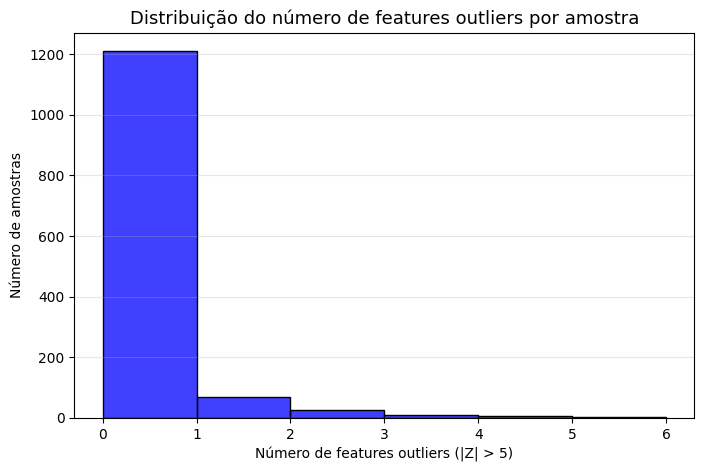

Contagem de amostras por número de features outliers:
0     1210
1       68
2       27
3       10
4        6
5        2
6        2
7        3
8        3
9        4
10       1
11       1
13       2
14       1
Name: n_outlier_feats, dtype: int64


In [194]:
# Histograma de contagem de outlier features por amostra
plt.figure(figsize=(8,5))
sns.histplot(df_merged_3d["n_outlier_feats"], bins=range(0, df_merged_2d["n_outlier_feats"].max()+2), 
             kde=False, color='blue', edgecolor='black')

plt.title("Distribuição do número de features outliers por amostra", fontsize=13)
plt.xlabel("Número de features outliers (|Z| > 5)")
plt.ylabel("Número de amostras")
plt.grid(axis='y', alpha=0.3)
plt.show()

# Estatísticas descritivas
vc = df_merged_3d["n_outlier_feats"].value_counts().sort_index()

print("Contagem de amostras por número de features outliers:")
print(vc)

In [195]:
df_merged_3d = df_merged_3d[df_merged_3d["n_outlier_feats"] <= 5].copy()

In [196]:
# Converter strings de tupla para tupla numérica apenas se o valor for uma string: 
df_3d['diagnostics_Image-original_Size'] = df_3d['diagnostics_Image-original_Size'].apply(
    lambda x: tuple(map(float, x.strip("()").split(","))) if isinstance(x, str) else x
)

# Converter strings de tupla para tupla numérica apenas se o valor for uma string: 
df_3d['diagnostics_Mask-original_Size'] = df_3d['diagnostics_Mask-original_Size'].apply(
    lambda x: tuple(map(float, x.strip("()").split(","))) if isinstance(x, str) else x
)
# Expandir as tuplas em colunas separadas (x, y, z) 
df_3d[['diagnostics_Image-original_Size_x', 
       'diagnostics_Image-original_Size_y', 
       'diagnostics_Image-original_Size_z']] = pd.DataFrame(
    df_3d['diagnostics_Image-original_Size'].tolist(), index=df_3d.index
)

df_3d[['diagnostics_Mask-original_Size_x', 
       'diagnostics_Mask-original_Size_y', 
       'diagnostics_Mask-original_Size_z']] = pd.DataFrame(
    df_3d['diagnostics_Mask-original_Size'].tolist(), index=df_3d.index
)

#Remover as colunas originais
df_3d = df_3d.drop(['diagnostics_Image-original_Size', 'diagnostics_Mask-original_Size'], axis=1)

In [197]:
df_merged_3d.shape

(1323, 90)

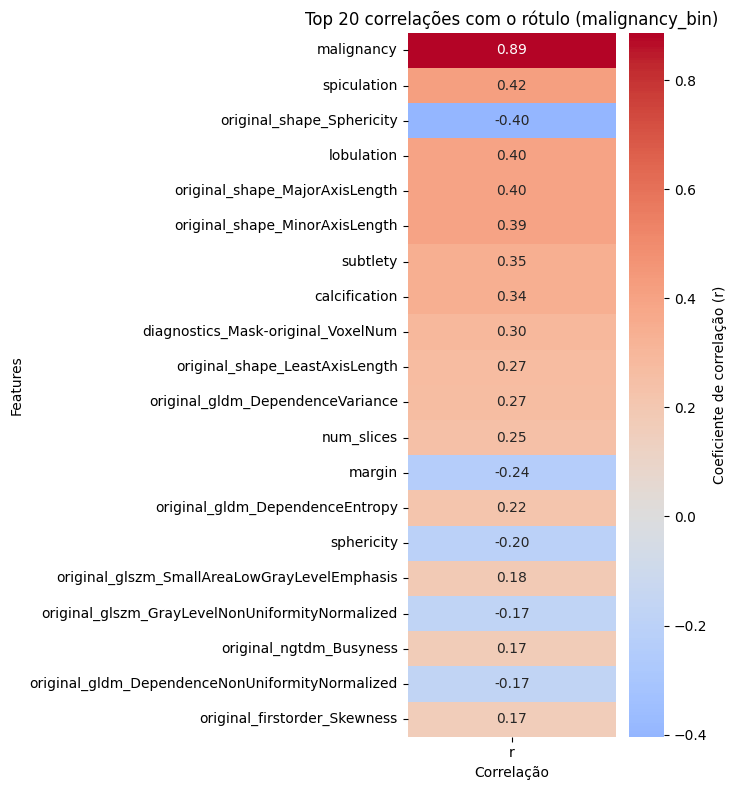

In [198]:
label = "malignancy_bin"

# Calcular correlação apenas com colunas numéricas
corr_lbl = (
    df_merged_3d.select_dtypes(include=[np.number])
    .corr()[label]
    .drop(label)
)

# Ordenar por |r| e selecionar Top-20
top = corr_lbl.reindex(corr_lbl.abs().sort_values(ascending=False).index).head(20)

# Criar heatmap vertical (altura ajustável)
plt.figure(figsize=(7, max(4, 0.4*len(top))))
sns.heatmap(
    top.to_frame(name="r"), 
    annot=True, fmt=".2f",
    cmap="coolwarm", center=0, 
    cbar_kws={"label": "Coeficiente de correlação (r)"}
)
plt.title("Top 20 correlações com o rótulo (malignancy_bin)")
plt.ylabel("Features")
plt.xlabel("Correlação")
plt.tight_layout()
plt.show()

In [199]:
# Enriquecer radiomics_features_3d.csv com engineered features 3D 

orig_cols_3d = set(df_merged_3d.columns)
eps = 1e-12

def get3d(*cands):
    for c in cands:
        if c in df_merged_3d.columns:
            return c
    return None

new3d = {}

In [200]:
# First-order 
c_mean  = get3d("original_firstorder_Mean")
c_std   = get3d("original_firstorder_StandardDeviation","original_firstorder_StdDev","original_firstorder_RMS")
if c_mean and c_std:
    new3d["eng3d_firstorder_CV"] = df_merged_3d[c_std] / (df_merged_3d[c_mean].abs() + eps)

c_iqr   = get3d("original_firstorder_InterquartileRange")
c_min   = get3d("original_firstorder_Minimum")
c_max   = get3d("original_firstorder_Maximum")
if c_iqr and c_min and c_max:
    new3d["eng3d_firstorder_IQR_over_Range"] = df_merged_3d[c_iqr] / ((df_merged_3d[c_max] - df_merged_3d[c_min]).abs() + eps)

c_entropy = get3d("original_firstorder_Entropy")
c_uniform = get3d("original_firstorder_Uniformity")
if c_entropy and c_uniform:
    new3d["eng3d_firstorder_Uniformity_over_Entropy"] = df_merged_3d[c_uniform] / (df_merged_3d[c_entropy].abs() + eps)

c_energy = get3d("original_firstorder_Energy","original_firstorder_TotalEnergy")
c_vol    = get3d("original_shape_MeshVolume","original_shape_VoxelVolume")  # volume 3D
if c_energy and c_vol:
    new3d["eng3d_firstorder_EnergyDensity"] = df_merged_3d[c_energy] / (df_merged_3d[c_vol].abs() + eps)


In [201]:
#  GLCM 
c_contrast = get3d("original_glcm_Contrast")
c_idm      = get3d("original_glcm_Idmn","original_glcm_Idm","original_glcm_InverseDifferenceMoment")
if c_contrast and c_idm:
    new3d["eng3d_glcm_Contrast_over_IDM"] = df_merged_3d[c_contrast] / (df_merged_3d[c_idm].abs() + eps)

c_corr = get3d("original_glcm_Correlation")
c_hom  = get3d("original_glcm_Homogeneity","original_glcm_Idn","original_glcm_Idmn")
if c_corr and c_hom:
    new3d["eng3d_glcm_Corr_times_Homog"] = df_merged_3d[c_corr] * df_merged_3d[c_hom]

In [202]:
# GLRLM 
c_sre = get3d("original_glrlm_ShortRunEmphasis")
c_lre = get3d("original_glrlm_LongRunEmphasis")
if c_sre and c_lre:
    new3d["eng3d_glrlm_SRE_over_LRE"] = df_merged_3d[c_sre] / (df_merged_3d[c_lre].abs() + eps)

c_glnu = get3d("original_glrlm_GrayLevelNonUniformity","original_glrlm_GrayLevelNonUniformityNormalized")
c_rlnu = get3d("original_glrlm_RunLengthNonUniformity","original_glrlm_RunLengthNonUniformityNormalized")
if c_glnu and c_rlnu:
    new3d["eng3d_glrlm_GLNU_over_RLNU"] = df_merged_3d[c_glnu] / (df_merged_3d[c_rlnu].abs() + eps)

In [203]:
#  GLSZM 
c_sae = get3d("original_glszm_SmallAreaEmphasis")
c_lae = get3d("original_glszm_LargeAreaEmphasis")
if c_sae and c_lae:
    new3d["eng3d_glszm_SAE_over_LAE"] = df_merged_3d[c_sae] / (df_merged_3d[c_lae].abs() + eps)

c_szn  = get3d("original_glszm_SizeZoneNonUniformity","original_glszm_SizeZoneNonUniformityNormalized")
c_glnu2= get3d("original_glszm_GrayLevelNonUniformity","original_glszm_GrayLevelNonUniformityNormalized")
if c_szn and c_glnu2:
    new3d["eng3d_glszm_SZN_over_GLNU"] = df_merged_3d[c_szn] / (df_merged_3d[c_glnu2].abs() + eps)

In [204]:
# GLDM / NGTDM 
c_bus = get3d("original_ngtdm_Busyness")
c_coa = get3d("original_ngtdm_Coarseness")
if c_bus and c_coa:
    new3d["eng3d_ngtdm_Busyness_over_Coarseness"] = df_merged_3d[c_bus] / (df_merged_3d[c_coa].abs() + eps)
    new3d["eng3d_ngtdm_InvCoarseness"] = 1.0 / (df_merged_3d[c_coa].abs() + eps)

c_depvar = get3d("original_gldm_DependenceVariance")
c_depnon = get3d("original_gldm_DependenceNonUniformity","original_gldm_DependenceNonUniformityNormalized")
if c_depvar and c_depnon:
    new3d["eng3d_gldm_DepVar_over_DepNonUni"] = df_merged_3d[c_depvar] / (df_merged_3d[c_depnon].abs() + eps)

In [205]:
# Forma 3D 
# superfície/volume, esfericidade aproximada e elongação
c_surf = get3d("original_shape_SurfaceArea")
c_vol  = get3d("original_shape_MeshVolume","original_shape_VoxelVolume")
if c_surf and c_vol:
    new3d["eng3d_shape_Surface_to_Volume"] = df_merged_3d[c_surf] / (df_merged_3d[c_vol].abs() + eps)
    # Sphericity ≈ (π^(1/3) * (6V)^(2/3)) / A  — se A e V existirem
    new3d["eng3d_shape_SphericityProxy"] = ((np.pi * (1.0/3.0)) * ((6.0 * df_merged_3d[c_vol].clip(lower=0) ) * (2.0/3.0))) / (df_merged_3d[c_surf].abs() + eps)

c_maj  = get3d("original_shape_MajorAxisLength","original_shape_Maximum3DDiameter")
c_min  = get3d("original_shape_MinorAxisLength","original_shape_LeastAxisLength")
if c_maj and c_min:
    new3d["eng3d_shape_ElongationProxy"] = (df_merged_3d[c_maj].abs() + eps) / (df_merged_3d[c_min].abs() + eps)

In [206]:
# Log-transform robusto em métricas explosivas
for cname in [c_energy, c_contrast, c_bus, c_depvar]:
    if isinstance(cname, str):
        new3d[f"eng3d_log1p__{cname}"] = np.log1p(df_merged_3d[cname].clip(lower=0))

# Consolidar/limpar/guardar
df_new3d = pd.DataFrame(new3d).replace([np.inf, -np.inf], np.nan)
df_out3d = pd.concat([df_merged_3d, df_new3d], axis=1)

print("Novas colunas 3D:", len(df_out3d.columns) - len(orig_cols_3d), "| shape:", df_3d.shape, "→", df_out3d.shape)

Novas colunas 3D: 8 | shape: (1340, 77) → (1323, 98)


In [207]:
# Salvar o DataFrame em um arquivo CSV com codificação UTF-8
df_out3d.to_csv('data_3d.csv', index=False, encoding='utf-8')